In [2]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import LSTM, SimpleRNN, Dense, Input
from keras.models import Sequential
import tensorflow.keras.optimizers
from keras.preprocessing.sequence import TimeseriesGenerator
import torch
import torch.nn as nn
from torch.autograd import Variable
import math, random
from google.colab import drive

In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


Text(0.5, 0.98, 'Saw_tooth signal')

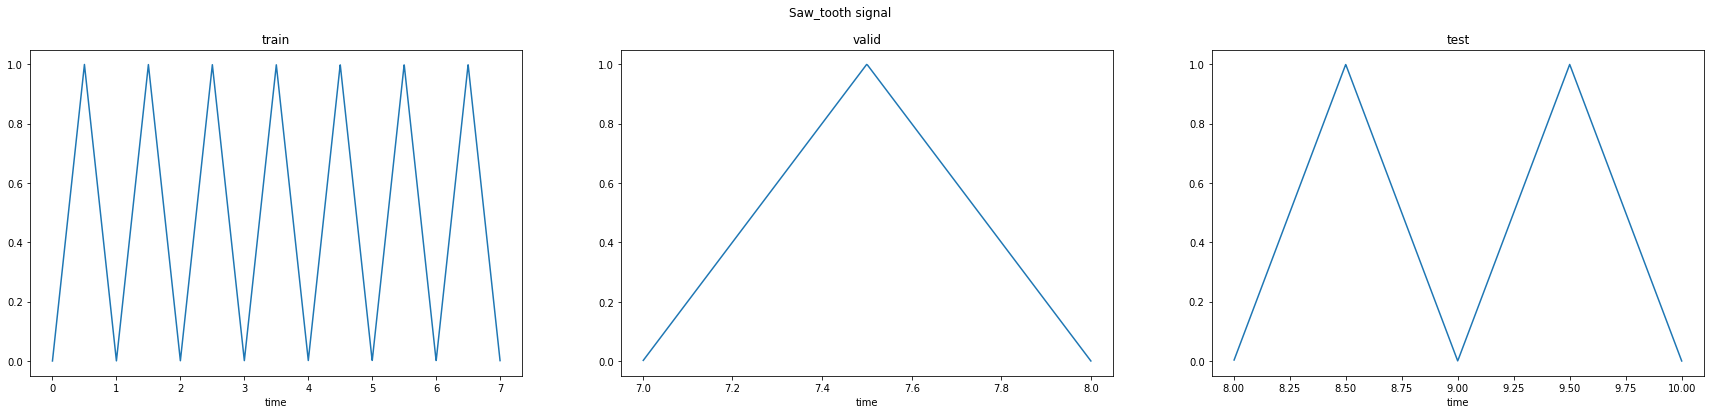

In [ ]:
t = np.linspace(0, 10, 5000)
signal1 = (1+signal.sawtooth(2 * np.pi * t, width=0.5))/2
train, time_train = signal1[:7*500], t[:7*500]
valid, time_valid = signal1[7*500:8*500], t[7*500:8*500]
test, time_test = signal1[8*500:], t[8*500:]



fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(30, 6))
ax[0].plot(time_train, train)
ax[0].set(xlabel  = 'time', title = 'train')
ax[1].plot(time_valid, valid)
ax[1].set(xlabel  = 'time', title = 'valid')
ax[2].plot(time_test, test)
ax[2].set(xlabel  = 'time', title = 'test')
fig.suptitle('Saw_tooth signal')

Text(0.5, 0.98, 'Saw_tooth signal(Gaussian Noisy, mean=0, var= 0.2)')

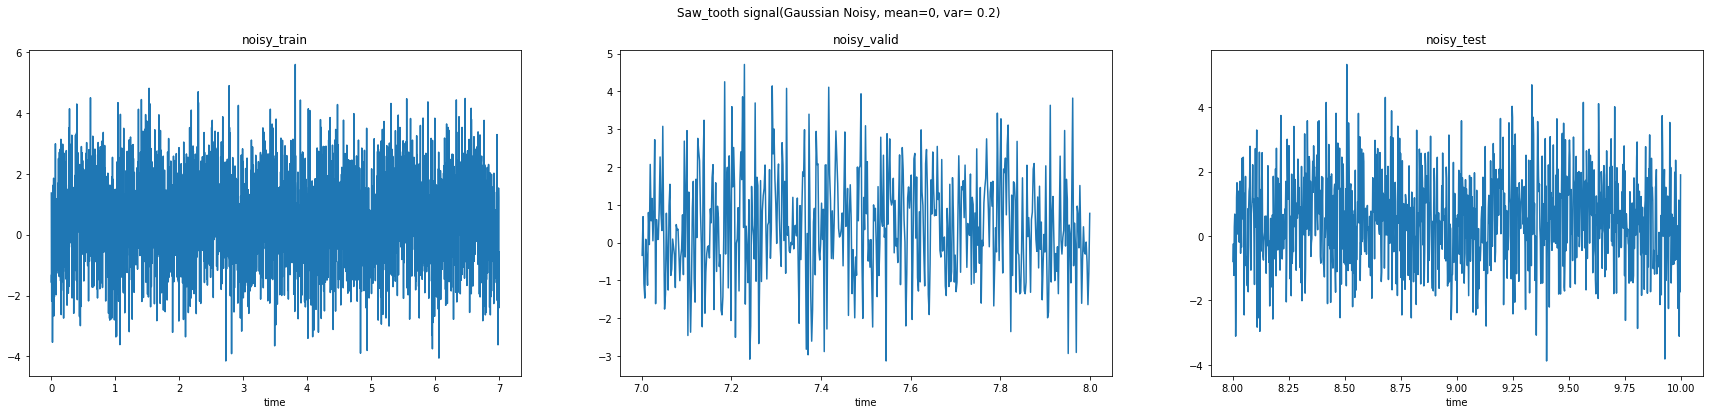

In [ ]:
noise = np.random.normal(0, 1.4, 5000)
noisy_train = train + noise[:7*500]
noisy_valid = valid + noise[7*500:8*500]
noisy_test = test + noise[8*500:]



fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(30, 6))
ax[0].plot(time_train, noisy_train)
ax[0].set(xlabel  = 'time', title = 'noisy_train')
ax[1].plot(time_valid, noisy_valid)
ax[1].set(xlabel  = 'time', title = 'noisy_valid')
ax[2].plot(time_test, noisy_test)
ax[2].set(xlabel  = 'time', title = 'noisy_test')
fig.suptitle('Saw_tooth signal(Gaussian Noisy, mean=0, var= 0.2)')

Text(0.5, 0.98, 'Saw_tooth signal(Uniform noisy))')

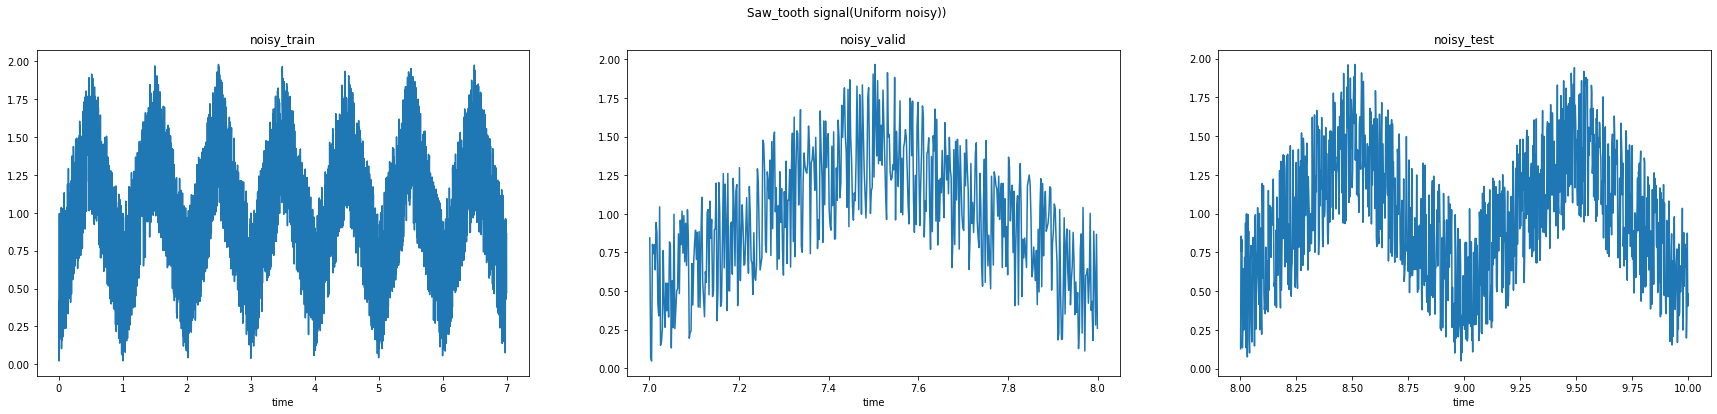

In [ ]:
noise2 = np.random.uniform(0, 1, 5000)
noisy_train2 = train + noise2[:7*500]
noisy_valid2 = valid + noise2[7*500:8*500]
noisy_test2 = test + noise2[8*500:]



fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(30, 6))
ax[0].plot(time_train, noisy_train2)
ax[0].set(xlabel  = 'time', title = 'noisy_train')
ax[1].plot(time_valid, noisy_valid2)
ax[1].set(xlabel  = 'time', title = 'noisy_valid')
ax[2].plot(time_test, noisy_test2)
ax[2].set(xlabel  = 'time', title = 'noisy_test')
fig.suptitle('Saw_tooth signal(Uniform noisy))')

# Preparing Data

In [ ]:
def saw(X, signal_freq=500.):
    return (1+signal.sawtooth(2 * np.pi * (X)/signal_freq, width=0.5))/2

# Adding uniform noise
def noisy(Y, noise_range=(-0.35, 0.35)):
    noise = np.random.normal(0, 1.4, 500)
    return Y + noise

# Create a noisy and clean sine wave 
def sample(sample_size):
    random_offset = random.randint(0, sample_size)
    X = np.arange(sample_size)
    out = saw(X + random_offset)
    inp = noisy(out)
    return inp, out


def create_dataset(n_samples=2000, sample_size=500):
    data_inp = np.zeros((n_samples, sample_size))
    data_out = np.zeros((n_samples, sample_size))
    
    for i in range(n_samples):
        sample_inp, sample_out = sample(sample_size)
        data_inp[i, :] = sample_inp
        data_out[i, :] = sample_out
    return data_inp, data_out


data_inp, data_out = create_dataset()
train_inp, train_out = data_inp, data_out

# Models : (RNN)

In [ ]:
input_dim = 1
hidden_size = 30
num_layers = 1

class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size, )
        self.act = nn.Tanh()
        self.drop = nn.Dropout(p=0.2)
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(self.drop(pred))).view(pred.data.shape[0], -1, 1)
        return pred

r= CustomRNN(input_dim, hidden_size, 1)

In [ ]:
batch_size = 16
optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for t in range(20):
  arr = np.arange(train_inp.shape[0])
  np.random.shuffle(arr)
  loss_temp = 0 
  k=0
  for j in range(0, train_inp.shape[0], batch_size):
    hidden = None
    inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    loss = loss_func(pred, out)
    #predictions.append(pred.data.numpy())
    loss.backward()
    optimizer.step()
    loss_temp += loss.data.numpy().sum()
    k += 1
  inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1), requires_grad=True)
  out = Variable(torch.Tensor(valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1))
  pred = r(inp)
  loss = loss_func(pred, out)
  val_loss = loss.data.numpy().sum()
  if t%2==0:
      print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}, valid_loss = {val_loss:.4f}')

epoch : 0, train_loss = 0.0110, valid_loss = 0.0042
epoch : 2, train_loss = 0.0025, valid_loss = 0.0028
epoch : 4, train_loss = 0.0022, valid_loss = 0.0026
epoch : 6, train_loss = 0.0022, valid_loss = 0.0026
epoch : 8, train_loss = 0.0022, valid_loss = 0.0025
epoch : 10, train_loss = 0.0024, valid_loss = 0.0025
epoch : 12, train_loss = 0.0021, valid_loss = 0.0024
epoch : 14, train_loss = 0.0020, valid_loss = 0.0026
epoch : 16, train_loss = 0.0019, valid_loss = 0.0024
epoch : 18, train_loss = 0.0019, valid_loss = 0.0022


In [ ]:
inp = Variable(torch.Tensor(noisy_test.reshape((2, -1, 1))), requires_grad=True)
out = Variable(torch.Tensor(test.reshape((2, -1, 1))))
pred = r(inp)

loss = loss_func(pred, out)
test_loss = loss.data.numpy().sum()

print(f'loss on test: {test_loss}')

loss on test: 0.0024264338426291943


In [ ]:
inp = Variable(torch.Tensor(noisy_train.reshape((7, -1, 1))), requires_grad=True)
pred = r(inp)
train_pred = pred.data.numpy().flatten()


inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))), requires_grad=True)
pred = r(inp)
valid_pred = pred.data.numpy().flatten()

inp = Variable(torch.Tensor(noisy_test.reshape((2, -1, 1))), requires_grad=True)
pred = r(inp)
test_pred = pred.data.numpy().flatten()

## Plots

Text(0.5, 0.98, 'Saw_tooth signal(Gaussian Noisy, mean=0, var= 0.2)')

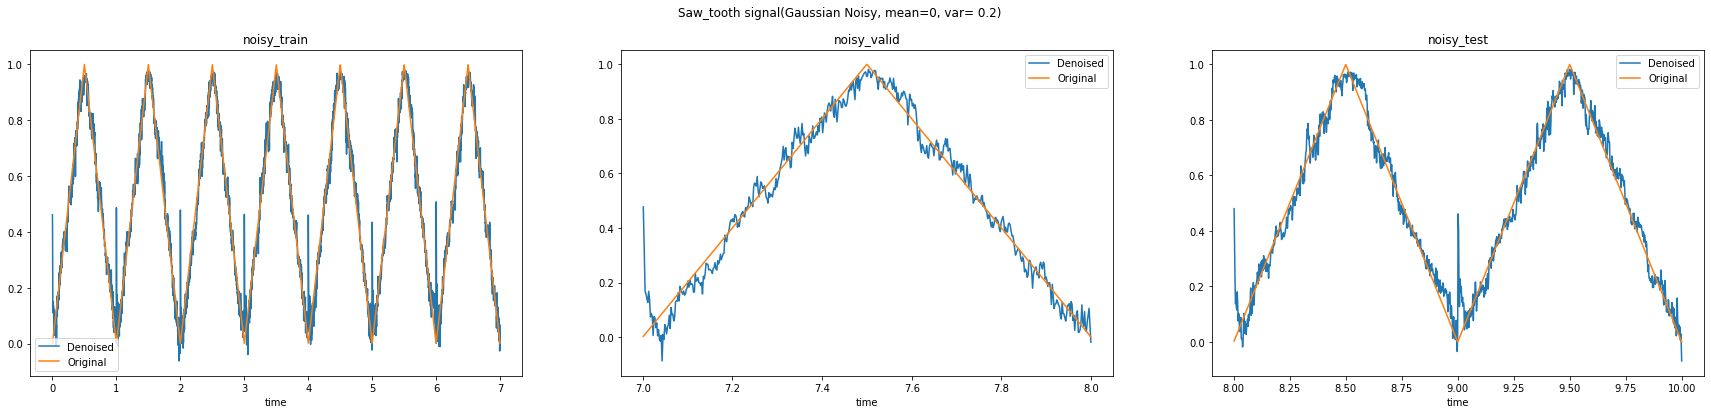

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(30, 6))
ax[0].plot(time_train, train_pred)
ax[0].plot(time_train, train)
ax[0].set(xlabel  = 'time', title = 'noisy_train')
ax[0].legend(['Denoised', 'Original'])
ax[1].plot(time_valid, valid_pred)
ax[1].plot(time_valid, valid)
ax[1].set(xlabel  = 'time', title = 'noisy_valid')
ax[1].legend(['Denoised', 'Original'])
ax[2].plot(time_test, test_pred)
ax[2].plot(time_test, test)
ax[2].set(xlabel  = 'time', title = 'noisy_test')
ax[2].legend(['Denoised', 'Original'])
fig.suptitle('Saw_tooth signal(Gaussian Noisy, mean=0, var= 0.2)')

## SNR's

In [ ]:
snr_train = 10*np.log10(np.mean(np.square(train))/ (np.mean(np.square(train-train_pred))))
snr_valid = 10*np.log10(np.mean(np.square(valid))/ (np.mean(np.square(valid-valid_pred))))
snr_test = 10*np.log10(np.mean(np.square(test))/ (np.mean(np.square(test-test_pred))))
print(f'SNR\'s for Train = {snr_train}\n \
        validation = {snr_valid} \n \
        test = {snr_test}') 

SNR's for Train = 21.504974967874833
         validation = 21.333390395218395 
         test = 21.2718015272962


# Models : (LSTM)

In [ ]:
input_dim = 1
hidden_size = 30
num_layers = 1

class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size, )
        self.act = nn.Tanh()
        self.drop = nn.Dropout(p=0.2)
    def forward(self, x):
        pred, (h, c) = self.rnn(x, None)
        pred = self.act(self.linear(self.drop(pred))).view(pred.data.shape[0], -1, 1)
        return pred

r= CustomRNN(input_dim, hidden_size, 1)

In [ ]:
batch_size = 16
optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for t in range(20):
  arr = np.arange(train_inp.shape[0])
  np.random.shuffle(arr)
  loss_temp = 0 
  k=0
  for j in range(0, train_inp.shape[0], batch_size):
    hidden = None
    inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    loss = loss_func(pred, out)
    #predictions.append(pred.data.numpy())
    loss.backward()
    optimizer.step()
    loss_temp += loss.data.numpy().sum()
    k += 1
  inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1), requires_grad=True)
  out = Variable(torch.Tensor(valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1))
  loss = loss_func(pred, out)
  val_loss = loss.data.numpy().sum()
  if t%2==0:
      print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}, valid_loss = {val_loss:.4f}')

epoch : 0, train_loss = 0.0184, valid_loss = 0.1732
epoch : 2, train_loss = 0.0026, valid_loss = 0.1607
epoch : 4, train_loss = 0.0022, valid_loss = 0.1420
epoch : 6, train_loss = 0.0019, valid_loss = 0.1549
epoch : 8, train_loss = 0.0016, valid_loss = 0.1832
epoch : 10, train_loss = 0.0013, valid_loss = 0.1459
epoch : 12, train_loss = 0.0012, valid_loss = 0.1478
epoch : 14, train_loss = 0.0011, valid_loss = 0.1867
epoch : 16, train_loss = 0.0010, valid_loss = 0.1329
epoch : 18, train_loss = 0.0009, valid_loss = 0.1666


In [ ]:
inp = Variable(torch.Tensor(noisy_train.reshape((7, -1, 1))), requires_grad=True)
pred = r(inp)
train_pred = pred.data.numpy().flatten()


inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))), requires_grad=True)
pred = r(inp)
valid_pred = pred.data.numpy().flatten()

inp = Variable(torch.Tensor(noisy_test.reshape((2, -1, 1))), requires_grad=True)
pred = r(inp)
test_pred = pred.data.numpy().flatten()

## Plots

Text(0.5, 0.98, 'Saw_tooth signal(Gaussian Noisy, mean=0, var= 0.2)')

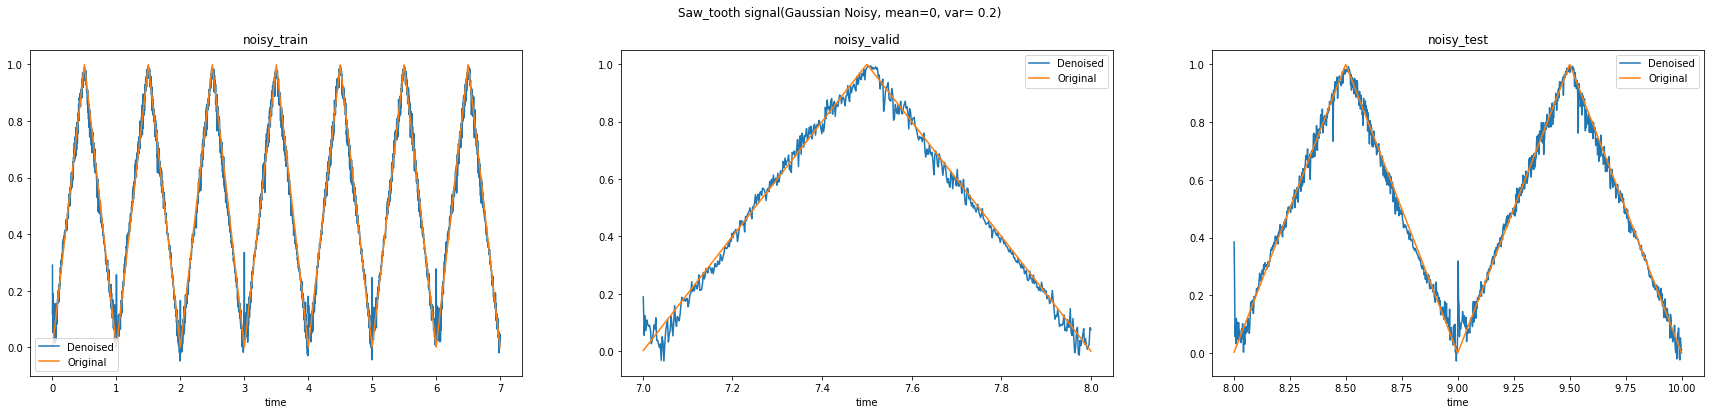

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(30, 6))
ax[0].plot(time_train, train_pred)
ax[0].plot(time_train, train)
ax[0].set(xlabel  = 'time', title = 'noisy_train')
ax[0].legend(['Denoised', 'Original'])
ax[1].plot(time_valid, valid_pred)
ax[1].plot(time_valid, valid)
ax[1].set(xlabel  = 'time', title = 'noisy_valid')
ax[1].legend(['Denoised', 'Original'])
ax[2].plot(time_test, test_pred)
ax[2].plot(time_test, test)
ax[2].set(xlabel  = 'time', title = 'noisy_test')
ax[2].legend(['Denoised', 'Original'])
fig.suptitle('Saw_tooth signal(Gaussian Noisy, mean=0, var= 0.2)')

## SNR's

In [ ]:
snr_train = 10*np.log10(np.mean(np.square(train))/ (np.mean(np.square(train-train_pred))))
snr_valid = 10*np.log10(np.mean(np.square(valid))/ (np.mean(np.square(valid-valid_pred))))
snr_test = 10*np.log10(np.mean(np.square(test))/ (np.mean(np.square(test-test_pred))))
print(f'SNR\'s for Train = {snr_train}\n \
        validation = {snr_valid} \n \
        test = {snr_test}') 

SNR's for Train = 25.758465508966957
         validation = 25.53496580829185 
         test = 24.879716461881955


# Effect of variance (RNN)

## Var = 0.7

In [ ]:
batch_size = 16
optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for t in range(20):
  arr = np.arange(train_inp.shape[0])
  np.random.shuffle(arr)
  loss_temp = 0 
  k=0
  for j in range(0, train_inp.shape[0], batch_size):
    hidden = None
    inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    loss = loss_func(pred, out)
    #predictions.append(pred.data.numpy())
    loss.backward()
    optimizer.step()
    loss_temp += loss.data.numpy().sum()
    k += 1
  inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1), requires_grad=True)
  out = Variable(torch.Tensor(valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1))
  loss = loss_func(pred, out)
  val_loss = loss.data.numpy().sum()
  if t%2==0:
      print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}, valid_loss = {val_loss:.4f}')

epoch : 0, train_loss = 0.0333, valid_loss = 0.0963
epoch : 2, train_loss = 0.0194, valid_loss = 0.1893
epoch : 4, train_loss = 0.0193, valid_loss = 0.1248
epoch : 6, train_loss = 0.0174, valid_loss = 0.1468
epoch : 8, train_loss = 0.0176, valid_loss = 0.1528
epoch : 10, train_loss = 0.0177, valid_loss = 0.1356
epoch : 12, train_loss = 0.0173, valid_loss = 0.1592
epoch : 14, train_loss = 0.0172, valid_loss = 0.1768
epoch : 16, train_loss = 0.0220, valid_loss = 0.1101
epoch : 18, train_loss = 0.0174, valid_loss = 0.2022


In [ ]:
inp = Variable(torch.Tensor(noisy_train.reshape((7, -1, 1))), requires_grad=True)
pred = r(inp)
train_pred = pred.data.numpy().flatten()


inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))), requires_grad=True)
pred = r(inp)
valid_pred = pred.data.numpy().flatten()

inp = Variable(torch.Tensor(noisy_test.reshape((2, -1, 1))), requires_grad=True)
pred = r(inp)
test_pred = pred.data.numpy().flatten()

Text(0.5, 0.98, 'Saw_tooth signal(Gaussian Noisy, mean=0, var= 01)')

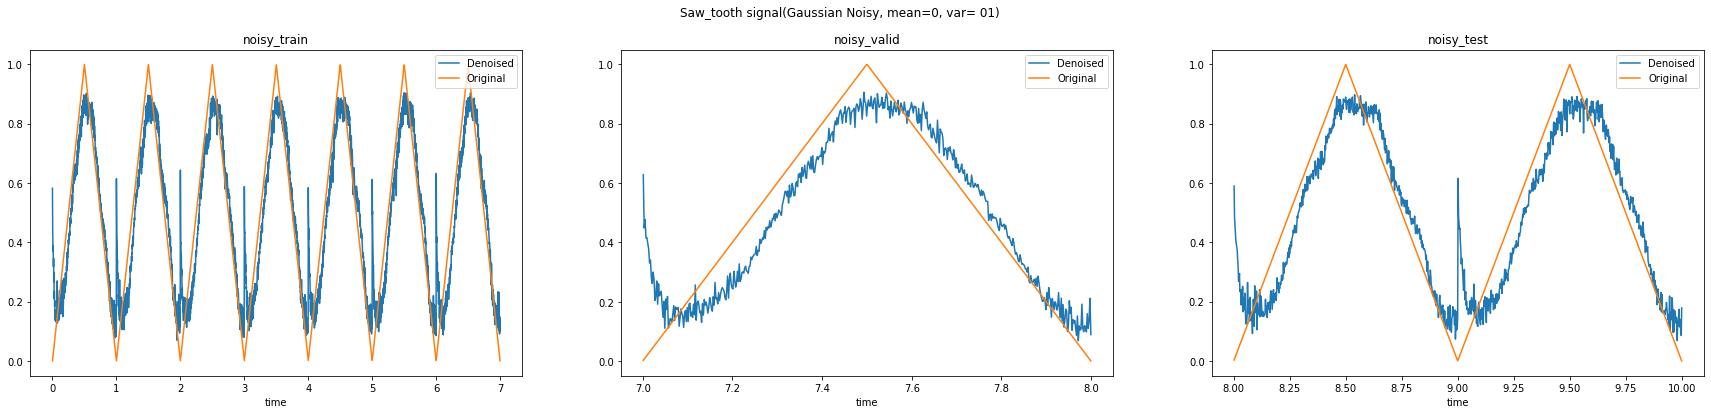

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(30, 6))
ax[0].plot(time_train, train_pred)
ax[0].plot(time_train, train)
ax[0].set(xlabel  = 'time', title = 'noisy_train')
ax[0].legend(['Denoised', 'Original'])
ax[1].plot(time_valid, valid_pred)
ax[1].plot(time_valid, valid)
ax[1].set(xlabel  = 'time', title = 'noisy_valid')
ax[1].legend(['Denoised', 'Original'])
ax[2].plot(time_test, test_pred)
ax[2].plot(time_test, test)
ax[2].set(xlabel  = 'time', title = 'noisy_test')
ax[2].legend(['Denoised', 'Original'])
fig.suptitle('Saw_tooth signal(Gaussian Noisy, mean=0, var= 01)')

## Var = 0.9

In [ ]:
batch_size = 16
optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for t in range(20):
  arr = np.arange(train_inp.shape[0])
  np.random.shuffle(arr)
  loss_temp = 0 
  k=0
  for j in range(0, train_inp.shape[0], batch_size):
    hidden = None
    inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    loss = loss_func(pred, out)
    #predictions.append(pred.data.numpy())
    loss.backward()
    optimizer.step()
    loss_temp += loss.data.numpy().sum()
    k += 1
  inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1), requires_grad=True)
  out = Variable(torch.Tensor(valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1))
  loss = loss_func(pred, out)
  val_loss = loss.data.numpy().sum()
  if t%2==0:
      print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}, valid_loss = {val_loss:.4f}')

epoch : 0, train_loss = 0.0267, valid_loss = 0.1108
epoch : 2, train_loss = 0.0227, valid_loss = 0.1902
epoch : 4, train_loss = 0.0232, valid_loss = 0.1475
epoch : 6, train_loss = 0.0225, valid_loss = 0.1669
epoch : 8, train_loss = 0.0229, valid_loss = 0.1199
epoch : 10, train_loss = 0.0253, valid_loss = 0.1339
epoch : 12, train_loss = 0.0232, valid_loss = 0.1579
epoch : 14, train_loss = 0.0227, valid_loss = 0.1165
epoch : 16, train_loss = 0.0230, valid_loss = 0.1237
epoch : 18, train_loss = 0.0225, valid_loss = 0.1407


In [ ]:
inp = Variable(torch.Tensor(noisy_train.reshape((7, -1, 1))), requires_grad=True)
pred = r(inp)
train_pred = pred.data.numpy().flatten()


inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))), requires_grad=True)
pred = r(inp)
valid_pred = pred.data.numpy().flatten()

inp = Variable(torch.Tensor(noisy_test.reshape((2, -1, 1))), requires_grad=True)
pred = r(inp)
test_pred = pred.data.numpy().flatten()

Text(0.5, 0.98, 'Saw_tooth signal(Gaussian Noisy, mean=0, var= 01)')

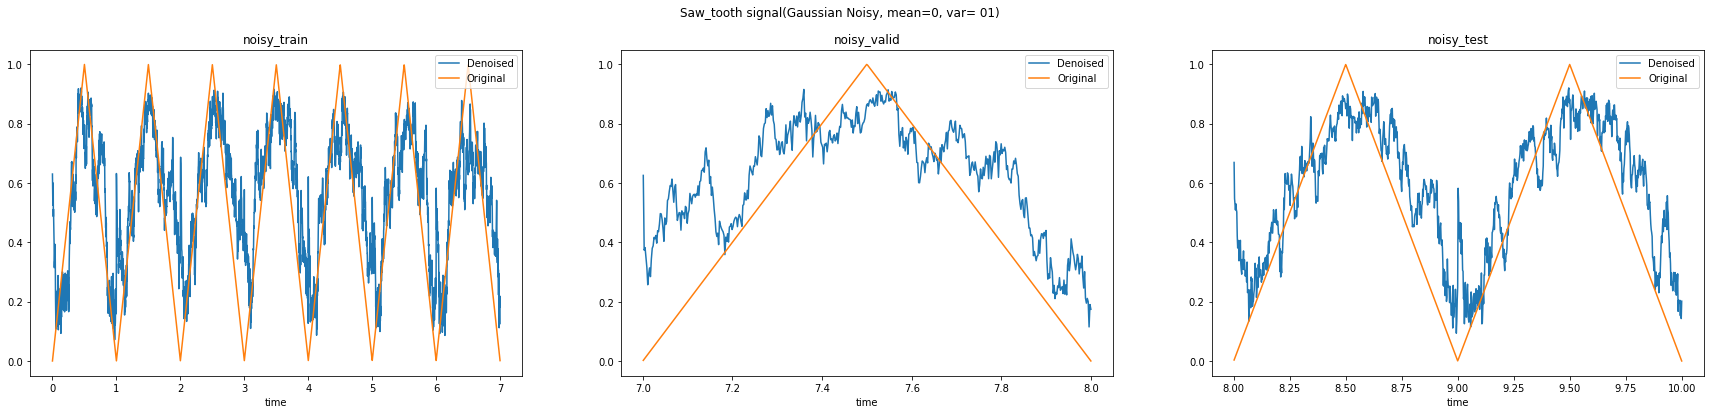

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(30, 6))
ax[0].plot(time_train, train_pred)
ax[0].plot(time_train, train)
ax[0].set(xlabel  = 'time', title = 'noisy_train')
ax[0].legend(['Denoised', 'Original'])
ax[1].plot(time_valid, valid_pred)
ax[1].plot(time_valid, valid)
ax[1].set(xlabel  = 'time', title = 'noisy_valid')
ax[1].legend(['Denoised', 'Original'])
ax[2].plot(time_test, test_pred)
ax[2].plot(time_test, test)
ax[2].set(xlabel  = 'time', title = 'noisy_test')
ax[2].legend(['Denoised', 'Original'])
fig.suptitle('Saw_tooth signal(Gaussian Noisy, mean=0, var= 01)')

## Var = 1

In [ ]:
batch_size = 16
optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for t in range(20):
  arr = np.arange(train_inp.shape[0])
  np.random.shuffle(arr)
  loss_temp = 0 
  k=0
  for j in range(0, train_inp.shape[0], batch_size):
    hidden = None
    inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    loss = loss_func(pred, out)
    #predictions.append(pred.data.numpy())
    loss.backward()
    optimizer.step()
    loss_temp += loss.data.numpy().sum()
    k += 1
  inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1), requires_grad=True)
  out = Variable(torch.Tensor(valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1))
  loss = loss_func(pred, out)
  val_loss = loss.data.numpy().sum()
  if t%2==0:
      print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}, valid_loss = {val_loss:.4f}')

epoch : 0, train_loss = 0.0432, valid_loss = 0.1338
epoch : 2, train_loss = 0.0290, valid_loss = 0.1423
epoch : 4, train_loss = 0.0284, valid_loss = 0.1419
epoch : 6, train_loss = 0.0271, valid_loss = 0.1402
epoch : 8, train_loss = 0.0273, valid_loss = 0.1305
epoch : 10, train_loss = 0.0280, valid_loss = 0.2077
epoch : 12, train_loss = 0.0266, valid_loss = 0.0975
epoch : 14, train_loss = 0.0258, valid_loss = 0.1472
epoch : 16, train_loss = 0.0261, valid_loss = 0.0947
epoch : 18, train_loss = 0.0257, valid_loss = 0.1212


In [ ]:
inp = Variable(torch.Tensor(noisy_train.reshape((7, -1, 1))), requires_grad=True)
pred = r(inp)
train_pred = pred.data.numpy().flatten()


inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))), requires_grad=True)
pred = r(inp)
valid_pred = pred.data.numpy().flatten()

inp = Variable(torch.Tensor(noisy_test.reshape((2, -1, 1))), requires_grad=True)
pred = r(inp)
test_pred = pred.data.numpy().flatten()

Text(0.5, 0.98, 'Saw_tooth signal(Gaussian Noisy, mean=0, var= 01)')

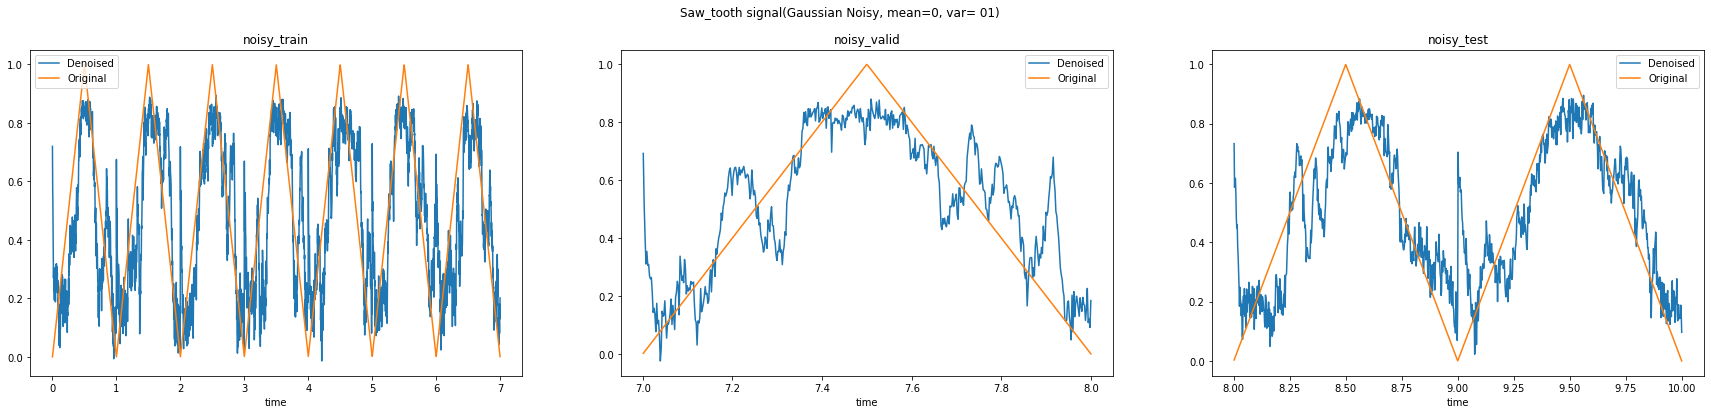

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(30, 6))
ax[0].plot(time_train, train_pred)
ax[0].plot(time_train, train)
ax[0].set(xlabel  = 'time', title = 'noisy_train')
ax[0].legend(['Denoised', 'Original'])
ax[1].plot(time_valid, valid_pred)
ax[1].plot(time_valid, valid)
ax[1].set(xlabel  = 'time', title = 'noisy_valid')
ax[1].legend(['Denoised', 'Original'])
ax[2].plot(time_test, test_pred)
ax[2].plot(time_test, test)
ax[2].set(xlabel  = 'time', title = 'noisy_test')
ax[2].legend(['Denoised', 'Original'])
fig.suptitle('Saw_tooth signal(Gaussian Noisy, mean=0, var= 01)')

## var = 1.4

In [ ]:
batch_size = 16
optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for t in range(20):
  arr = np.arange(train_inp.shape[0])
  np.random.shuffle(arr)
  loss_temp = 0 
  k=0
  for j in range(0, train_inp.shape[0], batch_size):
    hidden = None
    inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    loss = loss_func(pred, out)
    #predictions.append(pred.data.numpy())
    loss.backward()
    optimizer.step()
    loss_temp += loss.data.numpy().sum()
    k += 1
  inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1), requires_grad=True)
  out = Variable(torch.Tensor(valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1))
  loss = loss_func(pred, out)
  val_loss = loss.data.numpy().sum()
  if t%2==0:
      print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}, valid_loss = {val_loss:.4f}')

epoch : 0, train_loss = 0.0550, valid_loss = 0.1110
epoch : 2, train_loss = 0.0424, valid_loss = 0.1474
epoch : 4, train_loss = 0.0404, valid_loss = 0.1134
epoch : 6, train_loss = 0.0460, valid_loss = 0.1521
epoch : 8, train_loss = 0.0424, valid_loss = 0.1341
epoch : 10, train_loss = 0.0402, valid_loss = 0.1294
epoch : 12, train_loss = 0.0457, valid_loss = 0.1047
epoch : 14, train_loss = 0.0734, valid_loss = 0.0903
epoch : 16, train_loss = 0.0776, valid_loss = 0.0874
epoch : 18, train_loss = 0.0535, valid_loss = 0.1240


In [ ]:
inp = Variable(torch.Tensor(noisy_train.reshape((7, -1, 1))), requires_grad=True)
pred = r(inp)
train_pred = pred.data.numpy().flatten()


inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))), requires_grad=True)
pred = r(inp)
valid_pred = pred.data.numpy().flatten()

inp = Variable(torch.Tensor(noisy_test.reshape((2, -1, 1))), requires_grad=True)
pred = r(inp)
test_pred = pred.data.numpy().flatten()

Text(0.5, 0.98, 'Saw_tooth signal(Gaussian Noisy, mean=0, var= 01)')

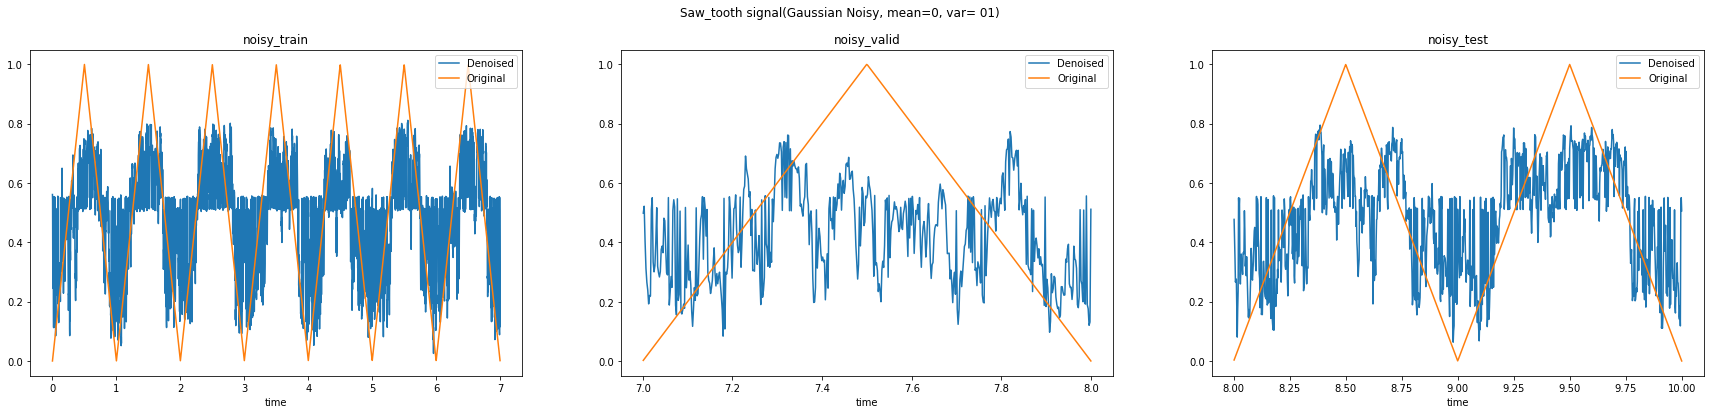

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(30, 6))
ax[0].plot(time_train, train_pred)
ax[0].plot(time_train, train)
ax[0].set(xlabel  = 'time', title = 'noisy_train')
ax[0].legend(['Denoised', 'Original'])
ax[1].plot(time_valid, valid_pred)
ax[1].plot(time_valid, valid)
ax[1].set(xlabel  = 'time', title = 'noisy_valid')
ax[1].legend(['Denoised', 'Original'])
ax[2].plot(time_test, test_pred)
ax[2].plot(time_test, test)
ax[2].set(xlabel  = 'time', title = 'noisy_test')
ax[2].legend(['Denoised', 'Original'])
fig.suptitle('Saw_tooth signal(Gaussian Noisy, mean=0, var= 01)')

## Results

WE Can see after Var \approx 1, we cant reconstruct the signal benefically anymore and model here fails. to do so

# Effect of Batch_size

In [ ]:
input_dim = 1
hidden_size = 30
num_layers = 1

class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size, )
        self.act = nn.Tanh()
        self.drop = nn.Dropout(p=0.2)
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(self.drop(pred))).view(pred.data.shape[0], -1, 1)
        return pred

r= CustomRNN(input_dim, hidden_size, 1)

In [ ]:
lossha = dict()
for i in range(5):
  batch_size = 2 ** (i+3)
  lossha[batch_size] = []
  r= CustomRNN(input_dim, hidden_size, 1)
  optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
  loss_func = nn.MSELoss()
  for t in range(20):
    arr = np.arange(train_inp.shape[0])
    np.random.shuffle(arr)
    loss_temp = 0 
    k=0
    for j in range(0, train_inp.shape[0], batch_size):
      hidden = None
      inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))), requires_grad=True)
      out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))) )
      pred = r(inp)
      optimizer.zero_grad()
      loss = loss_func(pred, out)
      #predictions.append(pred.data.numpy())
      loss.backward()
      optimizer.step()
      loss_temp += loss.data.numpy().sum()
      k += 1
    lossha[batch_size].append(loss_temp/k)
    inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1), requires_grad=True)
    out = Variable(torch.Tensor(valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1))
    pred = r(inp)
    loss = loss_func(pred, out)
    val_loss = loss.data.numpy().sum()
    if t%2==0:
        print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}, valid_loss = {val_loss:.4f}')

epoch : 0, train_loss = 0.0072, valid_loss = 0.0031
epoch : 2, train_loss = 0.0023, valid_loss = 0.0027
epoch : 4, train_loss = 0.0024, valid_loss = 0.0027
epoch : 6, train_loss = 0.0021, valid_loss = 0.0026
epoch : 8, train_loss = 0.0020, valid_loss = 0.0025
epoch : 10, train_loss = 0.0109, valid_loss = 0.0090
epoch : 12, train_loss = 0.0041, valid_loss = 0.0042
epoch : 14, train_loss = 0.0033, valid_loss = 0.0040
epoch : 16, train_loss = 0.0032, valid_loss = 0.0038
epoch : 18, train_loss = 0.0031, valid_loss = 0.0037
epoch : 0, train_loss = 0.0185, valid_loss = 0.0056
epoch : 2, train_loss = 0.0029, valid_loss = 0.0032
epoch : 4, train_loss = 0.0025, valid_loss = 0.0029
epoch : 6, train_loss = 0.0021, valid_loss = 0.0026
epoch : 8, train_loss = 0.0021, valid_loss = 0.0025
epoch : 10, train_loss = 0.0020, valid_loss = 0.0024
epoch : 12, train_loss = 0.0021, valid_loss = 0.0028
epoch : 14, train_loss = 0.0020, valid_loss = 0.0023
epoch : 16, train_loss = 0.0021, valid_loss = 0.0025
epo

## Plots

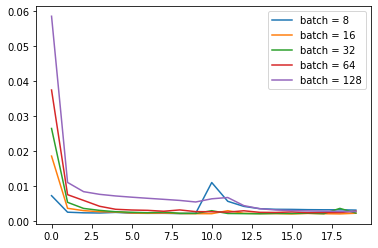

In [ ]:
plt.plot(lossha[8], label = 'batch = 8')
plt.plot(lossha[16], label = 'batch = 16')
plt.plot(lossha[32], label = 'batch = 32')
plt.plot(lossha[64], label = 'batch = 64')
plt.plot(lossha[128], label = 'batch = 128')
plt.legend()

# Effect OF LR

In [ ]:
lossha = dict()
lrs = [1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1]
batch_size = 16
r= CustomRNN(input_dim, hidden_size, 1)
for i in range(7):
  lossha[i] = []
  r= CustomRNN(input_dim, hidden_size, 1)
  optimizer = torch.optim.Adam(r.parameters(), lr=lrs[i])
  loss_func = nn.MSELoss()
  for t in range(20):
    arr = np.arange(train_inp.shape[0])
    np.random.shuffle(arr)
    loss_temp = 0 
    k=0
    for j in range(0, train_inp.shape[0], batch_size):
      hidden = None
      inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))), requires_grad=True)
      out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))) )
      pred = r(inp)
      optimizer.zero_grad()
      loss = loss_func(pred, out)
      loss.backward()
      optimizer.step()
      loss_temp += loss.data.numpy().sum()
      k += 1
    lossha[i].append(loss_temp/k)
    inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1), requires_grad=True)
    out = Variable(torch.Tensor(valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1))
    pred = r(inp)
    loss = loss_func(pred, out)
    val_loss = loss.data.numpy().sum()
    if t%2==0:
        print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}, valid_loss = {val_loss:.4f}')

epoch : 0, train_loss = 0.0388, valid_loss = 0.0075
epoch : 2, train_loss = 0.0053, valid_loss = 0.0049
epoch : 4, train_loss = 0.0035, valid_loss = 0.0036
epoch : 6, train_loss = 0.0030, valid_loss = 0.0033
epoch : 8, train_loss = 0.0027, valid_loss = 0.0030
epoch : 10, train_loss = 0.0025, valid_loss = 0.0028
epoch : 12, train_loss = 0.0023, valid_loss = 0.0027
epoch : 14, train_loss = 0.0023, valid_loss = 0.0026
epoch : 16, train_loss = 0.0022, valid_loss = 0.0025
epoch : 18, train_loss = 0.0021, valid_loss = 0.0024
epoch : 0, train_loss = 0.0495, valid_loss = 0.0082
epoch : 2, train_loss = 0.0055, valid_loss = 0.0052
epoch : 4, train_loss = 0.0037, valid_loss = 0.0039
epoch : 6, train_loss = 0.0030, valid_loss = 0.0033
epoch : 8, train_loss = 0.0027, valid_loss = 0.0030
epoch : 10, train_loss = 0.0026, valid_loss = 0.0029
epoch : 12, train_loss = 0.0024, valid_loss = 0.0028
epoch : 14, train_loss = 0.0023, valid_loss = 0.0027
epoch : 16, train_loss = 0.0021, valid_loss = 0.0026
epo

## Plots

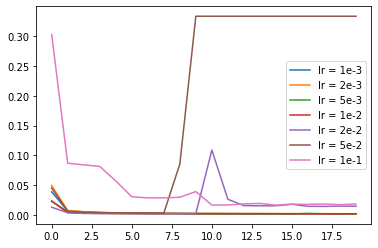

In [ ]:
plt.plot(lossha[0], label = 'lr = 1e-3')
plt.plot(lossha[1], label = 'lr = 2e-3')
plt.plot(lossha[2], label = 'lr = 5e-3')
plt.plot(lossha[3], label = 'lr = 1e-2')
plt.plot(lossha[4], label = 'lr = 2e-2')
plt.plot(lossha[5], label = 'lr = 5e-2')
plt.plot(lossha[6], label = 'lr = 1e-1')
plt.legend()

# Effect of Number of Epochs

In [ ]:
lossha = dict()
epochs = [5, 10, 20, 30, 40]
batch_size = 16
r= CustomRNN(input_dim, hidden_size, 1)
for i in range(5):
  lossha[i] = []
  r= CustomRNN(input_dim, hidden_size, 1)
  optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
  loss_func = nn.MSELoss()
  for t in range(epochs[i]):
    arr = np.arange(train_inp.shape[0])
    np.random.shuffle(arr)
    loss_temp = 0 
    k=0
    for j in range(0, train_inp.shape[0], batch_size):
      hidden = None
      inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))), requires_grad=True)
      out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))) )
      pred = r(inp)
      optimizer.zero_grad()
      loss = loss_func(pred, out)
      loss.backward()
      optimizer.step()
      loss_temp += loss.data.numpy().sum()
      k += 1
    lossha[i].append(loss_temp/k)
    inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1), requires_grad=True)
    out = Variable(torch.Tensor(valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1))
    pred = r(inp)
    loss = loss_func(pred, out)
    val_loss = loss.data.numpy().sum()
    if t%2==0:
        print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}, valid_loss = {val_loss:.4f}')

epoch : 0, train_loss = 0.0186, valid_loss = 0.0044
epoch : 2, train_loss = 0.0027, valid_loss = 0.0036
epoch : 4, train_loss = 0.0024, valid_loss = 0.0026
epoch : 0, train_loss = 0.0209, valid_loss = 0.0049
epoch : 2, train_loss = 0.0029, valid_loss = 0.0032
epoch : 4, train_loss = 0.0025, valid_loss = 0.0029
epoch : 6, train_loss = 0.0022, valid_loss = 0.0025
epoch : 8, train_loss = 0.0029, valid_loss = 0.0030
epoch : 0, train_loss = 0.0243, valid_loss = 0.0063
epoch : 2, train_loss = 0.0033, valid_loss = 0.0035
epoch : 4, train_loss = 0.0028, valid_loss = 0.0031
epoch : 6, train_loss = 0.0024, valid_loss = 0.0029
epoch : 8, train_loss = 0.0023, valid_loss = 0.0029
epoch : 10, train_loss = 0.0021, valid_loss = 0.0028
epoch : 12, train_loss = 0.0022, valid_loss = 0.0027
epoch : 14, train_loss = 0.0021, valid_loss = 0.0026
epoch : 16, train_loss = 0.0020, valid_loss = 0.0031
epoch : 18, train_loss = 0.0023, valid_loss = 0.0028
epoch : 0, train_loss = 0.0241, valid_loss = 0.0070
epoch :

## Plots

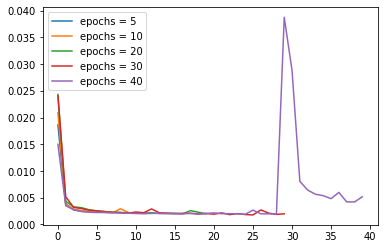

In [ ]:
plt.plot(lossha[0], label = 'epochs = 5')
plt.plot(lossha[1], label = 'epochs = 10')
plt.plot(lossha[2], label = 'epochs = 20')
plt.plot(lossha[3], label = 'epochs = 30')
plt.plot(lossha[4], label = 'epochs = 40')
plt.legend()

# Non_stationary noise

In [ ]:
def saw(X, signal_freq=500.):
    return (1+signal.sawtooth(2 * np.pi * (X)/signal_freq, width=0.5))/2

# Adding uniform noise
def noisy(Y, noise_range=(-0.35, 0.35)):
    means = np.array([-0.5, -0.2, 0, 0.2, 5])
    variances = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
    mean = np.random.choice(means)
    variance = np.random.choice(variances)
    noise = np.random.normal(mean, variance, 500)
    return Y + noise

# Create a noisy and clean sine wave 
def sample(sample_size):
    random_offset = random.randint(0, sample_size)
    X = np.arange(sample_size)
    out = saw(X + random_offset)
    inp = noisy(out)
    return inp, out


def create_dataset(n_samples=2000, sample_size=500):
    data_inp = np.zeros((n_samples, sample_size))
    data_out = np.zeros((n_samples, sample_size))
    
    for i in range(n_samples):
        sample_inp, sample_out = sample(sample_size)
        data_inp[i, :] = sample_inp
        data_out[i, :] = sample_out
    return data_inp, data_out


data_inp, data_out = create_dataset()
train_inp, train_out = data_inp, data_out

In [ ]:
batch_size = 16
optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for t in range(20):
  arr = np.arange(train_inp.shape[0])
  np.random.shuffle(arr)
  loss_temp = 0 
  k=0
  for j in range(0, train_inp.shape[0], batch_size):
    hidden = None
    inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    loss = loss_func(pred, out)
    #predictions.append(pred.data.numpy())
    loss.backward()
    optimizer.step()
    loss_temp += loss.data.numpy().sum()
    k += 1
  inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1), requires_grad=True)
  out = Variable(torch.Tensor(valid.reshape((1, -1, 1))).repeat(batch_size, 1, 1))
  loss = loss_func(pred, out)
  val_loss = loss.data.numpy().sum()
  if t%2==0:
      print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}, valid_loss = {val_loss:.4f}')

epoch : 0, train_loss = 0.0619, valid_loss = 0.1110
epoch : 2, train_loss = 0.0478, valid_loss = 0.1277
epoch : 4, train_loss = 0.0444, valid_loss = 0.1267
epoch : 6, train_loss = 0.0439, valid_loss = 0.1456
epoch : 8, train_loss = 0.0446, valid_loss = 0.1450
epoch : 10, train_loss = 0.0424, valid_loss = 0.1299
epoch : 12, train_loss = 0.0418, valid_loss = 0.1270
epoch : 14, train_loss = 0.0450, valid_loss = 0.1618
epoch : 16, train_loss = 0.0439, valid_loss = 0.1570
epoch : 18, train_loss = 0.0406, valid_loss = 0.1340


In [ ]:
inp = Variable(torch.Tensor(noisy_train.reshape((7, -1, 1))), requires_grad=True)
pred = r(inp)
train_pred = pred.data.numpy().flatten()


inp = Variable(torch.Tensor(noisy_valid.reshape((1, -1, 1))), requires_grad=True)
pred = r(inp)
valid_pred = pred.data.numpy().flatten()

inp = Variable(torch.Tensor(noisy_test.reshape((2, -1, 1))), requires_grad=True)
pred = r(inp)
test_pred = pred.data.numpy().flatten()

## plots

Text(0.5, 0.98, 'Saw_tooth signal(Gaussian Noisy, mean=0, var= 01)')

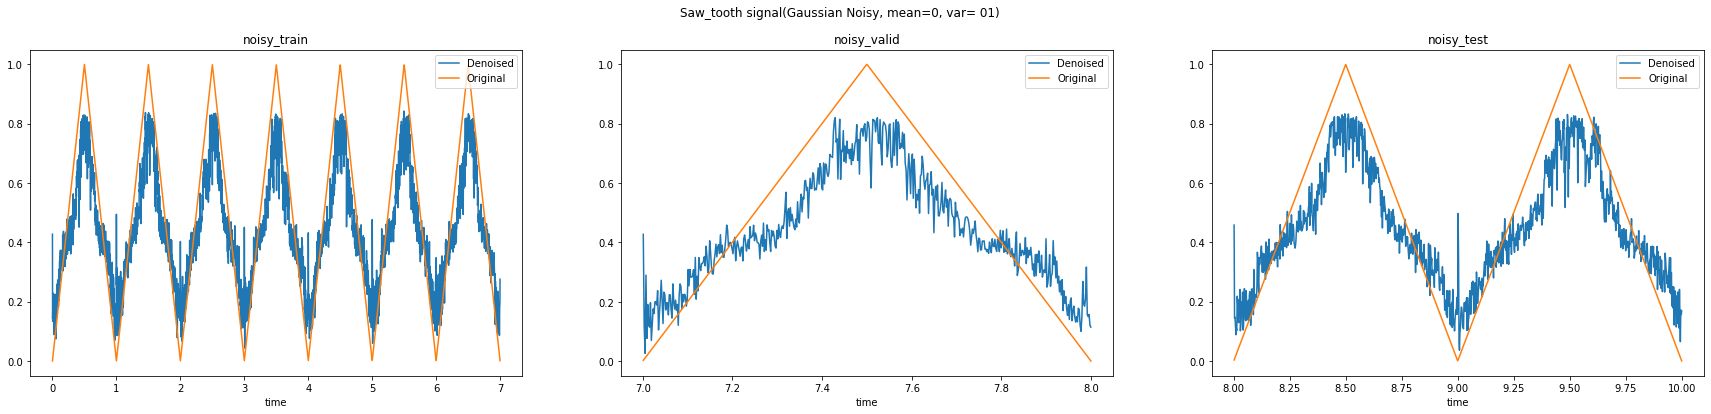

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(30, 6))
ax[0].plot(time_train, train_pred)
ax[0].plot(time_train, train)
ax[0].set(xlabel  = 'time', title = 'noisy_train')
ax[0].legend(['Denoised', 'Original'])
ax[1].plot(time_valid, valid_pred)
ax[1].plot(time_valid, valid)
ax[1].set(xlabel  = 'time', title = 'noisy_valid')
ax[1].legend(['Denoised', 'Original'])
ax[2].plot(time_test, test_pred)
ax[2].plot(time_test, test)
ax[2].set(xlabel  = 'time', title = 'noisy_test')
ax[2].legend(['Denoised', 'Original'])
fig.suptitle('Saw_tooth signal(Gaussian Noisy, mean=0, var= 01)')

## result

We Can see for non-stationary noises recpnstruction under the same circumstance can be much more difficult than the stationary part، but at general it would be kinda impossible to reconstruct from non_stationary nosise and here due to the low variance and periodic idientity of signal reconstruction looks kinda good

# Parametirc sweep

Consider that in every one of curves we oly use one period and therefor to answer your question, no. we dont need to get 10 rounds of circle

## Epitrochoid

### Prepare data

In [ ]:
def saw(X, signal_freq=500.):
    x = (8*np.cos(X) - 5*np.cos(8*X/3)).reshape(1, -1)
    y = (8*np.sin(X) - 5*np.sin(8*X/3)).reshape(1, -1)
    sig = np.concatenate((x, y), axis=0)
    return sig

# Adding uniform noise
def noisy(Y, noise_range=(-0.35, 0.35)):
    noise = np.random.normal(0, 0.6, size = (2,500))
    return Y + noise

# Create a noisy and clean sine wave 
def sample(sample_size):
    random_offset = random.randint(0, sample_size)
    X = np.arange(sample_size) * 6*np.pi/1000
    out = saw(X + random_offset)
    inp = noisy(out)
    return inp, out


def create_dataset(n_samples=2000, sample_size=500):
    data_inp = np.zeros((n_samples, 2,sample_size))
    data_out = np.zeros((n_samples, 2,sample_size))
    
    for i in range(n_samples):
        sample_inp, sample_out = sample(sample_size)
        data_inp[i] = sample_inp
        data_out[i] = sample_out
    return data_inp, data_out


data_inp, data_out = create_dataset()
train_inp, train_out = data_inp, data_out
train_inp = train_inp.transpose(0, 2, 1)
train_out = train_out.transpose(0, 2, 1)

### Cerate model

In [ ]:
input_dim = 2
hidden_size = 30
num_layers = 1

class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size, )
        self.act = nn.Tanh()
        self.drop = nn.Dropout(p=0.2)
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(self.drop(pred))).view(pred.data.shape[0], -1, 2)
        return pred

r= CustomRNN(input_dim, hidden_size, 2)

### Train model

In [ ]:
batch_size = 16
optimizer = torch.optim.Adam(r.parameters(), lr=2e-2)
loss_func = nn.MSELoss()

for t in range(20):
  arr = np.arange(train_inp.shape[0])
  np.random.shuffle(arr)
  loss_temp = 0 
  k=0
  for j in range(0, train_inp.shape[0], batch_size):
    hidden = None
    inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 2))), requires_grad=True)
    out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 2))) )
    pred = r(inp)
    optimizer.zero_grad()
    loss = loss_func(pred, out)
    #predictions.append(pred.data.numpy())
    loss.backward()
    optimizer.step()
    loss_temp += loss.data.numpy().sum()
    k += 1
  if t%2==0:
      print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}')

epoch : 0, train_loss = 34.4352
epoch : 2, train_loss = 34.2291
epoch : 4, train_loss = 34.2277
epoch : 6, train_loss = 34.2266
epoch : 8, train_loss = 34.2252
epoch : 10, train_loss = 34.2239
epoch : 12, train_loss = 34.2227
epoch : 14, train_loss = 34.2215
epoch : 16, train_loss = 34.2216
epoch : 18, train_loss = 34.2565


In [ ]:
X = np.arange(500) * 6*np.pi/500
x = (8*np.cos(X) - 5*np.cos(8*X/3)).reshape(1, -1)
y = (8*np.sin(X) - 5*np.sin(8*X/3)).reshape(1, -1)
sig = np.concatenate((x, y), axis=0)
noise = np.random.normal(0, 0.4, size = (2,500))
sig_noise = sig + noise
sig_noise = sig_noise.transpose(1, 0)

In [ ]:
inp = Variable(torch.Tensor(sig_noise.reshape((1, -1, 2))), requires_grad=True)
pred = r(inp)
train_pred = pred.data.numpy()[0].transpose(1, 0)

In [ ]:
sig_noise = sig_noise.transpose(1, 0)

### Results

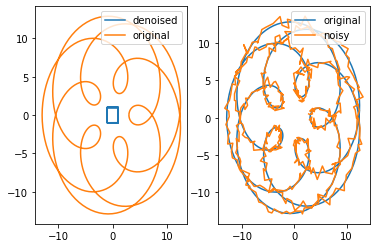

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2)
ax[0].plot(train_pred[0], train_pred[1], label = 'denoised')
ax[0].plot(sig[0], sig[1], label = 'original')
ax[0].legend()
ax[1].plot(sig[0], sig[1], label = 'original')
ax[1].plot(sig_noise[0], sig_noise[1], label = 'noisy')
ax[1].legend()

## Circle

### Prepare Data

In [ ]:
def saw(X, signal_freq=500.):
    x = np.cos(X).reshape(1, -1)
    y = np.sin(X).reshape(1, -1)
    sig = np.concatenate((x, y), axis=0)
    return sig

# Adding uniform noise
def noisy(Y, noise_range=(-0.35, 0.35)):
    noise = np.random.normal(0, 0.1, size = (2,500))
    return Y + noise

# Create a noisy and clean sine wave 
def sample(sample_size):
    random_offset = random.randint(0, sample_size)
    X = np.arange(sample_size) * 2*np.pi/1000
    out = saw(X + random_offset)
    inp = noisy(out)
    return inp, out


def create_dataset(n_samples=2000, sample_size=500):
    data_inp = np.zeros((n_samples, 2,sample_size))
    data_out = np.zeros((n_samples, 2,sample_size))
    
    for i in range(n_samples):
        sample_inp, sample_out = sample(sample_size)
        data_inp[i] = sample_inp
        data_out[i] = sample_out
    return data_inp, data_out


data_inp, data_out = create_dataset()
train_inp, train_out = data_inp, data_out
train_inp = train_inp.transpose(0, 2, 1)
train_out = train_out.transpose(0, 2, 1)

### Cerate model

In [ ]:
input_dim = 2
hidden_size = 30
num_layers = 1

class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size, )
        self.act = nn.Tanh()
        self.drop = nn.Dropout(p=0.2)
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(self.drop(pred))).view(pred.data.shape[0], -1, 2)
        return pred

r= CustomRNN(input_dim, hidden_size, 2)

### Train model

In [ ]:
batch_size = 16
optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for t in range(20):
  arr = np.arange(train_inp.shape[0])
  np.random.shuffle(arr)
  loss_temp = 0 
  k=0
  for j in range(0, train_inp.shape[0], batch_size):
    hidden = None
    inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 2))), requires_grad=True)
    out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 2))) )
    pred = r(inp)
    optimizer.zero_grad()
    loss = loss_func(pred, out)
    #predictions.append(pred.data.numpy())
    loss.backward()
    optimizer.step()
    loss_temp += loss.data.numpy().sum()
    k += 1
  if t%2==0:
      print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}')

epoch : 0, train_loss = 0.0242
epoch : 2, train_loss = 0.0052
epoch : 4, train_loss = 0.0044
epoch : 6, train_loss = 0.0040
epoch : 8, train_loss = 0.0038
epoch : 10, train_loss = 0.0037
epoch : 12, train_loss = 0.0037
epoch : 14, train_loss = 0.0036
epoch : 16, train_loss = 0.0036
epoch : 18, train_loss = 0.0035


In [ ]:
X = np.arange(500) * 2*np.pi/500
x = np.cos(X).reshape(1, -1)
y = np.sin(X).reshape(1, -1)
sig = np.concatenate((x, y), axis=0)
noise = np.random.normal(0, 0.1, size = (2,500))
sig_noise = sig + noise
sig_noise = sig_noise.transpose(1, 0)


In [ ]:
inp = Variable(torch.Tensor(sig_noise.reshape((1, -1, 2))), requires_grad=True)
pred = r(inp)
train_pred = pred.data.numpy()[0].transpose(1, 0)

In [ ]:
sig_noise = sig_noise.transpose(1, 0)

### Results

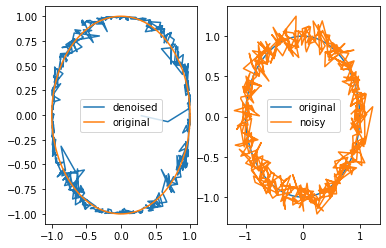

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2)
ax[0].plot(train_pred[0], train_pred[1], label = 'denoised')
ax[0].plot(sig[0], sig[1], label = 'original')
ax[0].legend()
ax[1].plot(sig[0], sig[1], label = 'original')
ax[1].plot(sig_noise[0], sig_noise[1], label = 'noisy')
ax[1].legend()

### Effect of variance

#### Var = 0.7

In [ ]:
batch_size = 16
optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for t in range(20):
  arr = np.arange(train_inp.shape[0])
  np.random.shuffle(arr)
  loss_temp = 0 
  k=0
  for j in range(0, train_inp.shape[0], batch_size):
    hidden = None
    inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 2))), requires_grad=True)
    out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 2))) )
    pred = r(inp)
    optimizer.zero_grad()
    loss = loss_func(pred, out)
    #predictions.append(pred.data.numpy())
    loss.backward()
    optimizer.step()
    loss_temp += loss.data.numpy().sum()
    k += 1
  if t%2==0:
      print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}')

epoch : 0, train_loss = 0.0506
epoch : 2, train_loss = 0.0213
epoch : 4, train_loss = 0.0192
epoch : 6, train_loss = 0.0187
epoch : 8, train_loss = 0.0175
epoch : 10, train_loss = 0.0175
epoch : 12, train_loss = 0.0170
epoch : 14, train_loss = 0.0174
epoch : 16, train_loss = 0.0169
epoch : 18, train_loss = 0.0170


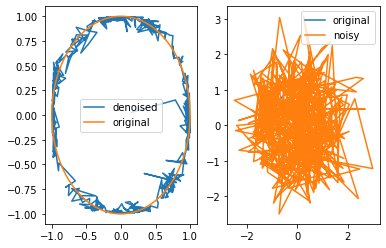

In [ ]:
X = np.arange(500) * 2*np.pi/500
x = np.cos(X).reshape(1, -1)
y = np.sin(X).reshape(1, -1)
sig = np.concatenate((x, y), axis=0)
noise = np.random.normal(0, 0.7, size = (2,500))
sig_noise = sig + noise
sig_noise = sig_noise.transpose(1, 0)

inp = Variable(torch.Tensor(sig_noise.reshape((1, -1, 2))), requires_grad=True)
pred = r(inp)
train_pred = pred.data.numpy()[0].transpose(1, 0)

sig_noise = sig_noise.transpose(1, 0)


fig, ax = plt.subplots(nrows = 1, ncols = 2)
ax[0].plot(train_pred[0], train_pred[1], label = 'denoised')
ax[0].plot(sig[0], sig[1], label = 'original')
ax[0].legend()
ax[1].plot(sig[0], sig[1], label = 'original')
ax[1].plot(sig_noise[0], sig_noise[1], label = 'noisy')
ax[1].legend()

#### Var = 0.9

In [ ]:
batch_size = 16
optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for t in range(20):
  arr = np.arange(train_inp.shape[0])
  np.random.shuffle(arr)
  loss_temp = 0 
  k=0
  for j in range(0, train_inp.shape[0], batch_size):
    hidden = None
    inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 2))), requires_grad=True)
    out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 2))) )
    pred = r(inp)
    optimizer.zero_grad()
    loss = loss_func(pred, out)
    #predictions.append(pred.data.numpy())
    loss.backward()
    optimizer.step()
    loss_temp += loss.data.numpy().sum()
    k += 1
  if t%2==0:
      print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}')

epoch : 0, train_loss = 0.0583
epoch : 2, train_loss = 0.0404
epoch : 4, train_loss = 0.0443
epoch : 6, train_loss = 0.0615
epoch : 8, train_loss = 0.0372
epoch : 10, train_loss = 0.0281
epoch : 12, train_loss = 0.0278
epoch : 14, train_loss = 0.0273
epoch : 16, train_loss = 0.0366
epoch : 18, train_loss = 0.0371


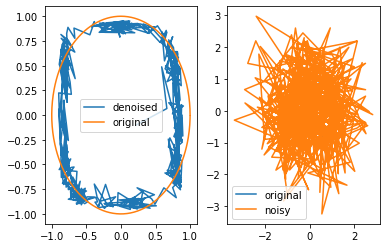

In [ ]:
X = np.arange(500) * 2*np.pi/500
x = np.cos(X).reshape(1, -1)
y = np.sin(X).reshape(1, -1)
sig = np.concatenate((x, y), axis=0)
noise = np.random.normal(0, 0.9, size = (2,500))
sig_noise = sig + noise
sig_noise = sig_noise.transpose(1, 0)

inp = Variable(torch.Tensor(sig_noise.reshape((1, -1, 2))), requires_grad=True)
pred = r(inp)
train_pred = pred.data.numpy()[0].transpose(1, 0)

sig_noise = sig_noise.transpose(1, 0)


fig, ax = plt.subplots(nrows = 1, ncols = 2)
ax[0].plot(train_pred[0], train_pred[1], label = 'denoised')
ax[0].plot(sig[0], sig[1], label = 'original')
ax[0].legend()
ax[1].plot(sig[0], sig[1], label = 'original')
ax[1].plot(sig_noise[0], sig_noise[1], label = 'noisy')
ax[1].legend()

#### Var = 1

In [ ]:
batch_size = 16
optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for t in range(20):
  arr = np.arange(train_inp.shape[0])
  np.random.shuffle(arr)
  loss_temp = 0 
  k=0
  for j in range(0, train_inp.shape[0], batch_size):
    hidden = None
    inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 2))), requires_grad=True)
    out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 2))) )
    pred = r(inp)
    optimizer.zero_grad()
    loss = loss_func(pred, out)
    #predictions.append(pred.data.numpy())
    loss.backward()
    optimizer.step()
    loss_temp += loss.data.numpy().sum()
    k += 1
  if t%2==0:
      print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}')

epoch : 0, train_loss = 0.0780
epoch : 2, train_loss = 0.3197
epoch : 4, train_loss = 0.1081
epoch : 6, train_loss = 0.0633
epoch : 8, train_loss = 0.3280
epoch : 10, train_loss = 0.2256
epoch : 12, train_loss = 0.1669
epoch : 14, train_loss = 0.1474
epoch : 16, train_loss = 0.1835
epoch : 18, train_loss = 0.2616


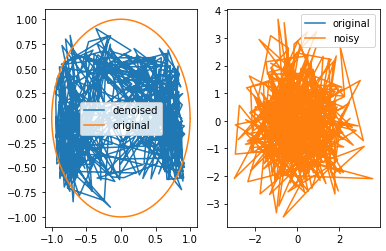

In [ ]:
X = np.arange(500) * 2*np.pi/500
x = np.cos(X).reshape(1, -1)
y = np.sin(X).reshape(1, -1)
sig = np.concatenate((x, y), axis=0)
noise = np.random.normal(0, 1, size = (2,500))
sig_noise = sig + noise
sig_noise = sig_noise.transpose(1, 0)

inp = Variable(torch.Tensor(sig_noise.reshape((1, -1, 2))), requires_grad=True)
pred = r(inp)
train_pred = pred.data.numpy()[0].transpose(1, 0)

sig_noise = sig_noise.transpose(1, 0)


fig, ax = plt.subplots(nrows = 1, ncols = 2)
ax[0].plot(train_pred[0], train_pred[1], label = 'denoised')
ax[0].plot(sig[0], sig[1], label = 'original')
ax[0].legend()
ax[1].plot(sig[0], sig[1], label = 'original')
ax[1].plot(sig_noise[0], sig_noise[1], label = 'noisy')
ax[1].legend()

#### REsult

Almost after var=0.9, reconstruct is kinda impossible

### Effect of batch size

In [ ]:
lossha = dict()
for i in range(5):
  batch_size = 2 ** (i+3)
  lossha[batch_size] = []
  optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
  loss_func = nn.MSELoss()

  for t in range(20):
    arr = np.arange(train_inp.shape[0])
    np.random.shuffle(arr)
    loss_temp = 0 
    k=0
    for j in range(0, train_inp.shape[0], batch_size):
      hidden = None
      inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 2))), requires_grad=True)
      out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 2))) )
      pred = r(inp)
      optimizer.zero_grad()
      loss = loss_func(pred, out)
      #predictions.append(pred.data.numpy())
      loss.backward()
      optimizer.step()
      loss_temp += loss.data.numpy().sum()
      k += 1
    lossha[batch_size].append(loss_temp/k)
    if t%2==0:
        print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}')

epoch : 0, train_loss = 0.0146
epoch : 2, train_loss = 0.0046
epoch : 4, train_loss = 0.0039
epoch : 6, train_loss = 0.0037
epoch : 8, train_loss = 0.0035
epoch : 10, train_loss = 0.0035
epoch : 12, train_loss = 0.0035
epoch : 14, train_loss = 0.0034
epoch : 16, train_loss = 0.0035
epoch : 18, train_loss = 0.0034
epoch : 0, train_loss = 0.0067
epoch : 2, train_loss = 0.0032
epoch : 4, train_loss = 0.0033
epoch : 6, train_loss = 0.0033
epoch : 8, train_loss = 0.0032
epoch : 10, train_loss = 0.0033
epoch : 12, train_loss = 0.0033
epoch : 14, train_loss = 0.0033
epoch : 16, train_loss = 0.0032
epoch : 18, train_loss = 0.0033
epoch : 0, train_loss = 0.0102
epoch : 2, train_loss = 0.0032
epoch : 4, train_loss = 0.0031
epoch : 6, train_loss = 0.0031
epoch : 8, train_loss = 0.0031
epoch : 10, train_loss = 0.0030
epoch : 12, train_loss = 0.0031
epoch : 14, train_loss = 0.0031
epoch : 16, train_loss = 0.0032
epoch : 18, train_loss = 0.0030
epoch : 0, train_loss = 0.0268
epoch : 2, train_loss = 

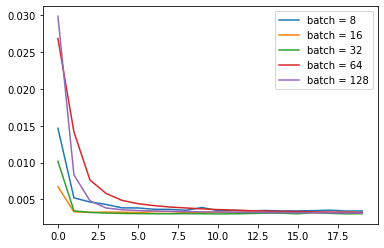

In [ ]:
plt.plot(lossha[8], label = 'batch = 8')
plt.plot(lossha[16], label = 'batch = 16')
plt.plot(lossha[32], label = 'batch = 32')
plt.plot(lossha[64], label = 'batch = 64')
plt.plot(lossha[128], label = 'batch = 128')
plt.legend()

### effect of LR

In [ ]:
lossha = dict()
lrs = [1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1]
for i in range(7):
  batch_size = 2 ** (i+3)
  lossha[i] = []
  r= CustomRNN(input_dim, hidden_size, 2)
  optimizer = torch.optim.Adam(r.parameters(), lr=lrs[i])
  loss_func = nn.MSELoss()
  for t in range(20):
    arr = np.arange(train_inp.shape[0])
    np.random.shuffle(arr)
    loss_temp = 0 
    k=0
    for j in range(0, train_inp.shape[0], batch_size):
      hidden = None
      inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 2))), requires_grad=True)
      out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 2))) )
      pred = r(inp)
      optimizer.zero_grad()
      loss = loss_func(pred, out)
      #predictions.append(pred.data.numpy())
      loss.backward()
      optimizer.step()
      loss_temp += loss.data.numpy().sum()
      k += 1
    lossha[i].append(loss_temp/k)
    if t%2==0:
        print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}')

epoch : 0, train_loss = 0.0665
epoch : 2, train_loss = 0.0079
epoch : 4, train_loss = 0.0058
epoch : 6, train_loss = 0.0046
epoch : 8, train_loss = 0.0041
epoch : 10, train_loss = 0.0039
epoch : 12, train_loss = 0.0037
epoch : 14, train_loss = 0.0036
epoch : 16, train_loss = 0.0035
epoch : 18, train_loss = 0.0034
epoch : 0, train_loss = 0.0852
epoch : 2, train_loss = 0.0083
epoch : 4, train_loss = 0.0067
epoch : 6, train_loss = 0.0055
epoch : 8, train_loss = 0.0045
epoch : 10, train_loss = 0.0040
epoch : 12, train_loss = 0.0038
epoch : 14, train_loss = 0.0037
epoch : 16, train_loss = 0.0035
epoch : 18, train_loss = 0.0034
epoch : 0, train_loss = 0.0751
epoch : 2, train_loss = 0.0087
epoch : 4, train_loss = 0.0065
epoch : 6, train_loss = 0.0058
epoch : 8, train_loss = 0.0052
epoch : 10, train_loss = 0.0044
epoch : 12, train_loss = 0.0039
epoch : 14, train_loss = 0.0038
epoch : 16, train_loss = 0.0037
epoch : 18, train_loss = 0.0040
epoch : 0, train_loss = 0.0968
epoch : 2, train_loss = 

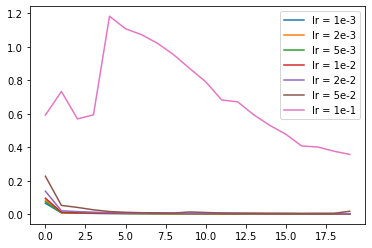

In [ ]:
plt.plot(lossha[0], label = 'lr = 1e-3')
plt.plot(lossha[1], label = 'lr = 2e-3')
plt.plot(lossha[2], label = 'lr = 5e-3')
plt.plot(lossha[3], label = 'lr = 1e-2')
plt.plot(lossha[4], label = 'lr = 2e-2')
plt.plot(lossha[5], label = 'lr = 5e-2')
plt.plot(lossha[6], label = 'lr = 1e-1')
plt.legend()

### effect of number of epochs

In [ ]:
lossha = dict()
epochs = [5, 10, 20, 30, 40]
for i in range(5):
  batch_size = 2 ** (i+3)
  lossha[i] = []
  r= CustomRNN(input_dim, hidden_size, 2)
  optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
  loss_func = nn.MSELoss()
  for t in range(epochs[i]):
    arr = np.arange(train_inp.shape[0])
    np.random.shuffle(arr)
    loss_temp = 0 
    k=0
    for j in range(0, train_inp.shape[0], batch_size):
      hidden = None
      inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 2))), requires_grad=True)
      out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 2))) )
      pred = r(inp)
      optimizer.zero_grad()
      loss = loss_func(pred, out)
      #predictions.append(pred.data.numpy())
      loss.backward()
      optimizer.step()
      loss_temp += loss.data.numpy().sum()
      k += 1
    lossha[i].append(loss_temp/k)
    if t%2==0:
        print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}')

epoch : 0, train_loss = 0.0179
epoch : 2, train_loss = 0.0045
epoch : 4, train_loss = 0.0040
epoch : 0, train_loss = 0.0292
epoch : 2, train_loss = 0.0053
epoch : 4, train_loss = 0.0046
epoch : 6, train_loss = 0.0043
epoch : 8, train_loss = 0.0040
epoch : 0, train_loss = 0.0548
epoch : 2, train_loss = 0.0077
epoch : 4, train_loss = 0.0062
epoch : 6, train_loss = 0.0053
epoch : 8, train_loss = 0.0047
epoch : 10, train_loss = 0.0041
epoch : 12, train_loss = 0.0045
epoch : 14, train_loss = 0.0037
epoch : 16, train_loss = 0.0040
epoch : 18, train_loss = 0.0035
epoch : 0, train_loss = 0.0865
epoch : 2, train_loss = 0.0095
epoch : 4, train_loss = 0.0073
epoch : 6, train_loss = 0.0063
epoch : 8, train_loss = 0.0057
epoch : 10, train_loss = 0.0060
epoch : 12, train_loss = 0.0045
epoch : 14, train_loss = 0.0047
epoch : 16, train_loss = 0.0041
epoch : 18, train_loss = 0.0041
epoch : 20, train_loss = 0.0040
epoch : 22, train_loss = 0.0041
epoch : 24, train_loss = 0.0043
epoch : 26, train_loss = 0

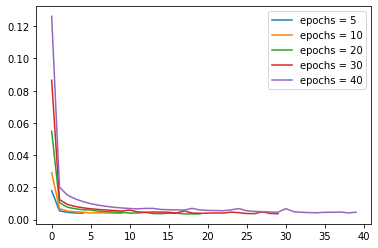

In [ ]:
plt.plot(lossha[0], label = 'epochs = 5')
plt.plot(lossha[1], label = 'epochs = 10')
plt.plot(lossha[2], label = 'epochs = 20')
plt.plot(lossha[3], label = 'epochs = 30')
plt.plot(lossha[4], label = 'epochs = 40')
plt.legend()

### non-stationary noise

In [ ]:
def saw(X, signal_freq=500.):
    x = np.cos(X).reshape(1, -1)
    y = np.sin(X).reshape(1, -1)
    sig = np.concatenate((x, y), axis=0)
    return sig

# Adding uniform noise
def noisy(Y, noise_range=(-0.35, 0.35)):
    means = np.array([-0.5, -0.2, 0, 0.2, 5])
    variances = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
    mean = np.random.choice(means)
    variance = np.random.choice(variances)
    noise = np.random.normal(mean, variance, size = (2,500))
    return Y + noise

# Create a noisy and clean sine wave 
def sample(sample_size):
    random_offset = random.randint(0, sample_size)
    X = np.arange(sample_size) * 2*np.pi/1000
    out = saw(X + random_offset)
    inp = noisy(out)
    return inp, out


def create_dataset(n_samples=2000, sample_size=500):
    data_inp = np.zeros((n_samples, 2,sample_size))
    data_out = np.zeros((n_samples, 2,sample_size))
    
    for i in range(n_samples):
        sample_inp, sample_out = sample(sample_size)
        data_inp[i] = sample_inp
        data_out[i] = sample_out
    return data_inp, data_out


data_inp, data_out = create_dataset()
train_inp, train_out = data_inp, data_out
train_inp = train_inp.transpose(0, 2, 1)
train_out = train_out.transpose(0, 2, 1)

In [ ]:
batch_size = 16
optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.MSELoss()
r= CustomRNN(input_dim, hidden_size, 2)

for t in range(20):
  arr = np.arange(train_inp.shape[0])
  np.random.shuffle(arr)
  loss_temp = 0 
  k=0
  for j in range(0, train_inp.shape[0], batch_size):
    hidden = None
    inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 2))), requires_grad=True)
    out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 2))) )
    pred = r(inp)
    optimizer.zero_grad()
    loss = loss_func(pred, out)
    #predictions.append(pred.data.numpy())
    loss.backward()
    optimizer.step()
    loss_temp += loss.data.numpy().sum()
    k += 1
  if t%2==0:
      print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}')

epoch : 0, train_loss = 0.5681
epoch : 2, train_loss = 0.5680
epoch : 4, train_loss = 0.5681
epoch : 6, train_loss = 0.5682
epoch : 8, train_loss = 0.5683
epoch : 10, train_loss = 0.5682
epoch : 12, train_loss = 0.5681
epoch : 14, train_loss = 0.5682
epoch : 16, train_loss = 0.5682
epoch : 18, train_loss = 0.5682


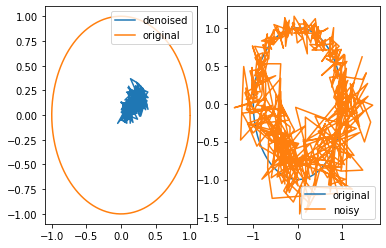

In [ ]:
X = np.arange(500) * 2*np.pi/500
x = np.cos(X).reshape(1, -1)
y = np.sin(X).reshape(1, -1)
sig = np.concatenate((x, y), axis=0)
noise = np.random.normal(0, 0.1, size = (2,250))
sig_noise = np.zeros((2, 500))
sig_noise[:, :250] = sig[:, :250] + noise
noise = np.random.normal(0.2, 0.3, size = (2,250))
sig_noise[:, 250:] = sig[:, 250:] + noise
sig_noise = sig_noise.transpose(1, 0)

inp = Variable(torch.Tensor(sig_noise.reshape((1, -1, 2))), requires_grad=True)
pred = r(inp)
train_pred = pred.data.numpy()[0].transpose(1, 0)

sig_noise = sig_noise.transpose(1, 0)


fig, ax = plt.subplots(nrows = 1, ncols = 2)
ax[0].plot(train_pred[0], train_pred[1], label = 'denoised')
ax[0].plot(sig[0], sig[1], label = 'original')
ax[0].legend()
ax[1].plot(sig[0], sig[1], label = 'original')
ax[1].plot(sig_noise[0], sig_noise[1], label = 'noisy')
ax[1].legend()

## Nephroid

### Prepare Data

In [ ]:
def saw(X, signal_freq=500.):
    x = 2*(np.cos(3*X)-3*np.cos(X)).reshape(1, -1)
    y = 2*(np.sin(3*X)-3*np.sin(X)).reshape(1, -1)
    sig = np.concatenate((x, y), axis=0)
    return sig

# Adding uniform noise
def noisy(Y, noise_range=(-0.35, 0.35)):
    noise = np.random.normal(0, 0.01, size = (2,500))
    return Y + noise

# Create a noisy and clean sine wave 
def sample(sample_size):
    random_offset = random.randint(0, sample_size)
    X = np.arange(sample_size) * 2*np.pi/1000
    out = saw(X + random_offset)
    inp = noisy(out)
    return inp, out


def create_dataset(n_samples=2000, sample_size=500):
    data_inp = np.zeros((n_samples, 2,sample_size))
    data_out = np.zeros((n_samples, 2,sample_size))
    
    for i in range(n_samples):
        sample_inp, sample_out = sample(sample_size)
        data_inp[i] = sample_inp
        data_out[i] = sample_out
    return data_inp, data_out


data_inp, data_out = create_dataset()
train_inp, train_out = data_inp, data_out
train_inp = train_inp.transpose(0, 2, 1)
train_out = train_out.transpose(0, 2, 1)

### Cerate model

In [ ]:
input_dim = 2
hidden_size = 30
num_layers = 1

class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size, )
        self.act = nn.Tanh()
        self.drop = nn.Dropout(p=0.2)
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(self.drop(pred))).view(pred.data.shape[0], -1, 2)
        return pred

r= CustomRNN(input_dim, hidden_size, 2)

### Train model

In [ ]:
batch_size = 16
optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for t in range(20):
  arr = np.arange(train_inp.shape[0])
  np.random.shuffle(arr)
  loss_temp = 0 
  k=0
  for j in range(0, train_inp.shape[0], batch_size):
    hidden = None
    inp = Variable(torch.Tensor(train_inp[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 2))), requires_grad=True)
    out = Variable(torch.Tensor(train_out[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 2))) )
    pred = r(inp)
    optimizer.zero_grad()
    loss = loss_func(pred, out)
    #predictions.append(pred.data.numpy())
    loss.backward()
    optimizer.step()
    loss_temp += loss.data.numpy().sum()
    k += 1
  if t%2==0:
      print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}')

epoch : 0, train_loss = 13.5001
epoch : 2, train_loss = 13.2550
epoch : 4, train_loss = 13.2507
epoch : 6, train_loss = 13.2496
epoch : 8, train_loss = 13.2491
epoch : 10, train_loss = 13.2484
epoch : 12, train_loss = 13.2482
epoch : 14, train_loss = 13.2481
epoch : 16, train_loss = 13.2481
epoch : 18, train_loss = 13.2479


In [ ]:
X = np.arange(500) * 2*np.pi/500
x = 2*(np.cos(3*X)-3*np.cos(X)).reshape(1, -1)
y = 2*(np.sin(3*X)-3*np.sin(X)).reshape(1, -1)
sig = np.concatenate((x, y), axis=0)
noise = np.random.normal(0, 0.01, size = (2,500))
sig_noise = sig + noise
sig_noise = sig_noise.transpose(1, 0)

In [ ]:
inp = Variable(torch.Tensor(sig_noise.reshape((1, -1, 2))), requires_grad=True)
pred = r(inp)
train_pred = pred.data.numpy()[0].transpose(1, 0)

In [ ]:
sig_noise = sig_noise.transpose(1, 0)

### Results

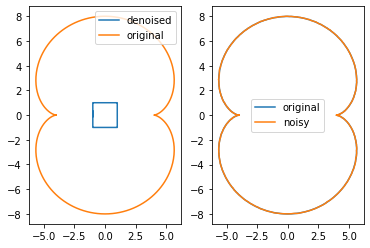

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2)
ax[0].plot(train_pred[0], train_pred[1], label = 'denoised')
ax[0].plot(sig[0], sig[1], label = 'original')
ax[0].legend()
ax[1].plot(sig[0], sig[1], label = 'original')
ax[1].plot(sig_noise[0], sig_noise[1], label = 'noisy')
ax[1].legend()

# بخش و

In [89]:
import librosa
import IPython.display as ipd
import librosa.display
data, sr = librosa.load('/content/drive/My Drive/message.wav', sr=None)

In [90]:
noised = data + np.random.normal(0,0.3,size = data.shape[0])

In [80]:
ipd.Audio(noised, rate = sr)

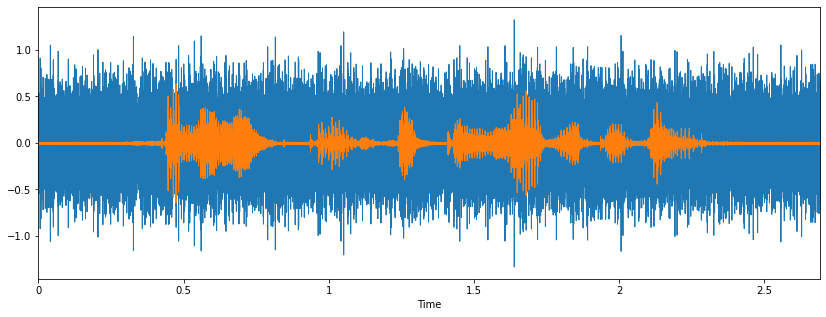

In [92]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(noised, sr=sr)
librosa.display.waveplot(data, sr=sr)

In [82]:
data = data.reshape(209, -1)
noised = noised.reshape(209, -1)

In [83]:
input_dim = 1
hidden_size = 30
num_layers = 1

class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size, )
        self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred

r= CustomRNN(input_dim, hidden_size, 1)

In [84]:
batch_size = 16
optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for t in range(20):
  arr = np.arange(data.shape[0])
  np.random.shuffle(arr)
  loss_temp = 0 
  k=0
  for j in range(0, data.shape[0], batch_size):
    hidden = None
    inp = Variable(torch.Tensor(data[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(noised[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1,1))) )
    pred = r(inp)
    optimizer.zero_grad()
    loss = loss_func(pred, out)
    #predictions.append(pred.data.numpy())
    loss.backward()
    optimizer.step()
    loss_temp += loss.data.numpy().sum()
    k += 1
  if t%2==0:
      print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}')

epoch : 0, train_loss = 0.1038
epoch : 2, train_loss = 0.0918
epoch : 4, train_loss = 0.0925
epoch : 6, train_loss = 0.0915
epoch : 8, train_loss = 0.0903
epoch : 10, train_loss = 0.0924
epoch : 12, train_loss = 0.0902
epoch : 14, train_loss = 0.0904
epoch : 16, train_loss = 0.0901
epoch : 18, train_loss = 0.0902


In [85]:
inp = Variable(torch.Tensor(noised.reshape((1, -1, 1))), requires_grad=True)
pred = r(inp)
train_pred = pred.data.numpy().flatten()

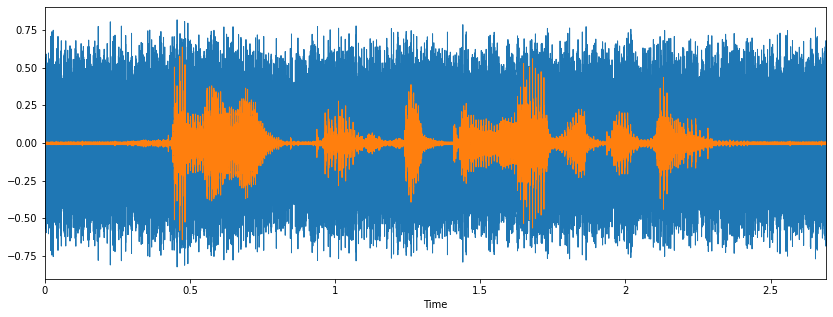

In [86]:
plt.figure(figsize=(14, 5))
librosa.display.waveplot(train_pred, sr=sr)
librosa.display.waveplot(data.reshape(-1), sr=sr)

In [87]:
ipd.Audio(train_pred, rate = sr)

Results happen to be not so good and well as expected like other parts :( !

# بخش ز

In [ ]:
from keras.preprocessing import image

## load and preprocess

In [ ]:
a = image.load_img('city-sample.jpeg', target_size=(224, 224))

In [ ]:
a = image.img_to_array(a)
a = np.mean(a, axis=2)
a = a/255
noised = a + np.random.normal(0, 0.03, size = (224, 224))
a = a.reshape(-1)
noised = noised.reshape(-1)

## Create model

In [ ]:
input_dim = 1
hidden_size = 30
num_layers = 1

class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size, )
        self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 1)
        return pred

r= CustomRNN(input_dim, hidden_size, 1)

In [ ]:
b = a.reshape(196, 256) # (Building samples for trainign with lenght of 256 and number of 196)
bn = noised.reshape(196, 256) #(Noisy)

## Train model

In [ ]:
batch_size = 16
optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for t in range(20):
  arr = np.arange(b.shape[0])
  np.random.shuffle(arr)
  loss_temp = 0 
  k=0
  for j in range(0, b.shape[0], batch_size):
    hidden = None
    inp = Variable(torch.Tensor(bn[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))), requires_grad=True)
    out = Variable(torch.Tensor(b[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 1))) )
    pred = r(inp)
    optimizer.zero_grad()
    loss = loss_func(pred, out)
    #predictions.append(pred.data.numpy())
    loss.backward()
    optimizer.step()
    loss_temp += loss.data.numpy().sum()
    k += 1
  if t%2==0:
      print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}')

epoch : 0, train_loss = 0.0378
epoch : 2, train_loss = 0.0085
epoch : 4, train_loss = 0.0020
epoch : 6, train_loss = 0.0013
epoch : 8, train_loss = 0.0013
epoch : 10, train_loss = 0.0013
epoch : 12, train_loss = 0.0012
epoch : 14, train_loss = 0.0013
epoch : 16, train_loss = 0.0012
epoch : 18, train_loss = 0.0012


## PRedict and visualize

In [ ]:
inp = Variable(torch.Tensor(bn.reshape((-1, 256, 1))), requires_grad=True)
pred = r(inp) #PRedicting the picture
train_pred = pred.data.numpy().flatten()
train_pred = train_pred.reshape(224, 224)

[Text(0.5, 1.0, 'Reconstructed Picture')]

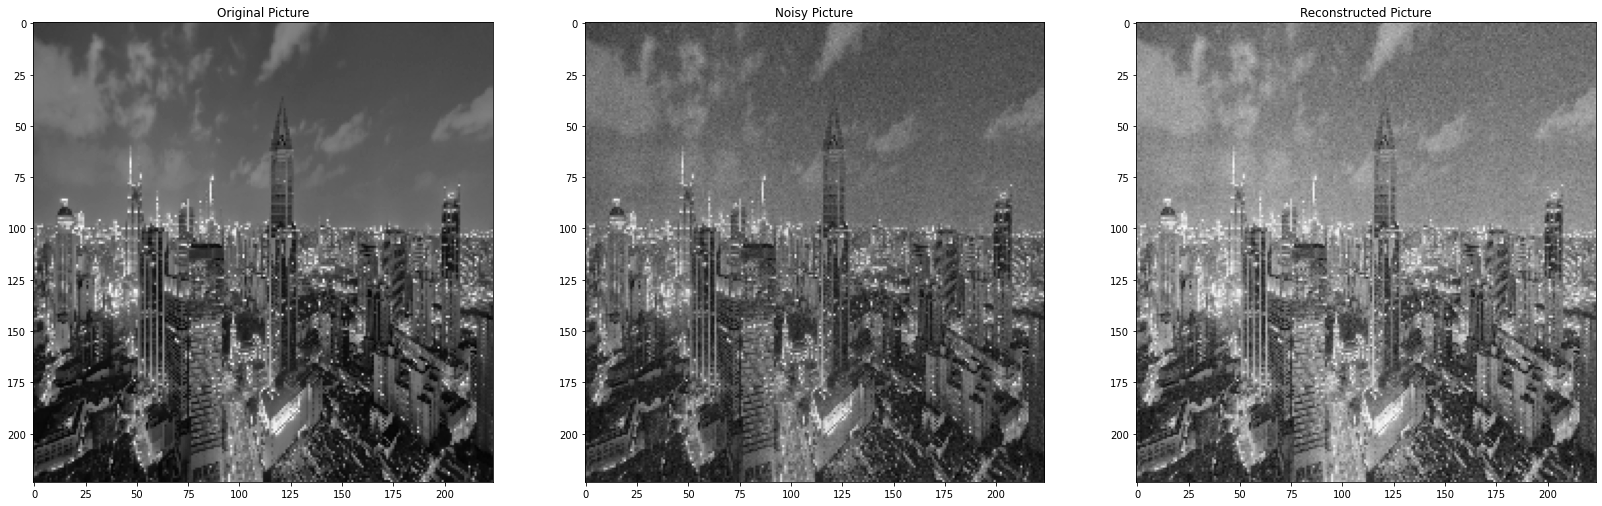

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (28, 40))
ax[0].imshow(b.reshape(224, 224), cmap = 'gray')
ax[0].set(title = 'Original Picture')
ax[1].imshow(bn.reshape(224, 224), cmap = 'gray')
ax[1].set(title = 'Noisy Picture')
ax[2].imshow(train_pred, cmap = 'gray')
ax[2].set(title = 'Reconstructed Picture')

## PSNR

In [ ]:
def PSNR(ori, rec):
  return 20 * np.log10(1/np.sqrt(np.mean((ori - rec) ** 2)))

In [ ]:
o1 = PSNR(b.reshape(224, 224), train_pred)
o2 = PSNR(b.reshape(224, 224), bn.reshape(224, 224))
o3 = PSNR(train_pred, bn.reshape(224, 224))

print(f'PSNR is : {o1} \n \
PSNR of nosisy and. original picture is : {o2} \n \
PSNR of reconstructed and noisy is : {o3}')

PSNR is : 29.097087108181363 
 PSNR of nosisy and. original picture is : 30.460292895018654 
 PSNR of reconstructed and noisy is : 33.45873939469178


## بخش ز امتیازی

## load and preprocess

In [ ]:
a = image.load_img('city-sample.jpeg', target_size=(224, 224))
a = image.img_to_array(a)
a = a/255
noised = a + np.random.normal(0, 0.03, size = (224, 224, 3))

In [ ]:
b = a.reshape(196, 256, 3) # (Building samples for trainign with lenght of 256 and number of 196)
bn = noised.reshape(196, 256, 3) #(Noisy)

## Create model

In [ ]:
input_dim = 3
hidden_size = 30
num_layers = 1

class CustomRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CustomRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.linear = nn.Linear(hidden_size, output_size, )
        self.act = nn.Tanh()
    def forward(self, x):
        pred, hidden = self.rnn(x, None)
        pred = self.act(self.linear(pred)).view(pred.data.shape[0], -1, 3)
        return pred

r= CustomRNN(input_dim, hidden_size, 3)

## Train model

In [ ]:
batch_size = 16
optimizer = torch.optim.Adam(r.parameters(), lr=1e-2)
loss_func = nn.MSELoss()

for t in range(20):
  arr = np.arange(b.shape[0])
  np.random.shuffle(arr)
  loss_temp = 0 
  k=0
  for j in range(0, b.shape[0], batch_size):
    hidden = None
    inp = Variable(torch.Tensor(bn[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 3))), requires_grad=True)
    out = Variable(torch.Tensor(b[arr[j:j+batch_size], :].reshape((arr[j:j+batch_size].shape[0], -1, 3))) )
    pred = r(inp)
    optimizer.zero_grad()
    loss = loss_func(pred, out)
    #predictions.append(pred.data.numpy())
    loss.backward()
    optimizer.step()
    loss_temp += loss.data.numpy().sum()
    k += 1
  if t%2==0:
      print(f'epoch : {t}, train_loss = {loss_temp/k:.4f}')

epoch : 0, train_loss = 0.0521
epoch : 2, train_loss = 0.0080
epoch : 4, train_loss = 0.0028
epoch : 6, train_loss = 0.0017
epoch : 8, train_loss = 0.0016
epoch : 10, train_loss = 0.0015
epoch : 12, train_loss = 0.0015
epoch : 14, train_loss = 0.0014
epoch : 16, train_loss = 0.0014
epoch : 18, train_loss = 0.0014


## Predict and visuzlize

In [ ]:
inp = Variable(torch.Tensor(bn.reshape((-1, 256, 3))), requires_grad=True)
pred = r(inp) #PRedicting the picture
train_pred = pred.data.numpy().flatten()
train_pred = train_pred.reshape(224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[Text(0.5, 1.0, 'Reconstructed Picture')]

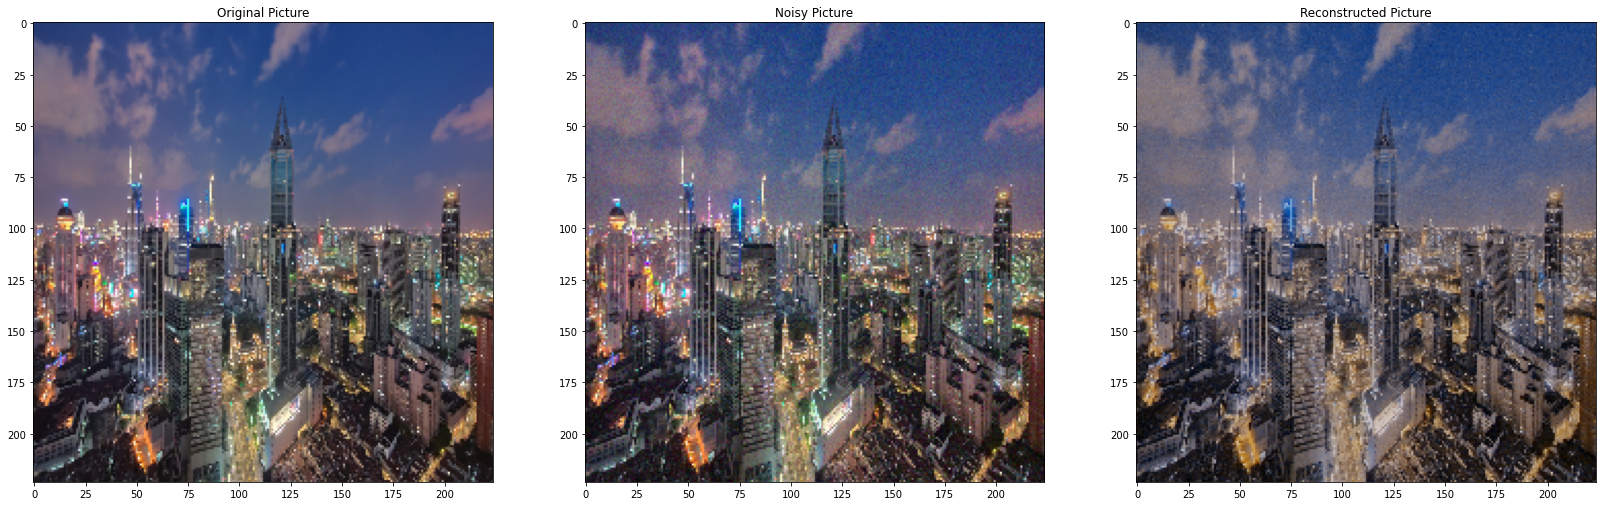

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (28, 40))
ax[0].imshow(b.reshape(224, 224, 3), cmap = 'gray')
ax[0].set(title = 'Original Picture')
ax[1].imshow(bn.reshape(224, 224, 3), cmap = 'gray')
ax[1].set(title = 'Noisy Picture')
ax[2].imshow(train_pred, cmap = 'gray')
ax[2].set(title = 'Reconstructed Picture')

## PSNR

In [ ]:
o1 = PSNR(b.reshape(224, 224, 3), train_pred)
o2 = PSNR(b.reshape(224, 224,3 ), bn.reshape(224, 224, 3))
o3 = PSNR(train_pred, bn.reshape(224, 224, 3))

print(f'PSNR is : {o1} \n \
PSNR of nosisy and. original picture is : {o2} \n \
PSNR of reconstructed and noisy is : {o3}')

PSNR is : 28.727223296328802 
 PSNR of nosisy and. original picture is : 30.471835069828145 
 PSNR of reconstructed and noisy is : 29.227934761402416


## Result

We can see that reconstruction in small variances is quite convincing, 

but we should take note that 

> Data input of picture after vectorizing should be sequential menaing that consecutive batchs better have consecutive pixels, and also that picture should be normalized before handing to the model due to large numbers of loss which could lead to grading exploding